In [1]:
import os, sys
import numpy as np
#import matplotlib.pyplot as plt
#import pickle
from datetime import datetime as dt

import pandas as pd

import torch
#from torch.utils.data import DataLoader

In [2]:
# To load personal libraries (currently in folder 'tools'):
sys.path.append('tools')

#import generic_tools_pl as gt   # like hexcolor(), ...
#import specific_nn_tools_pl as nnt  # like CustomDataset(), Net(), train_model() 
import generic_tools_pl as gt
from generic_tools_pl import region

gt.region = input("Enter the region number: ")
region=gt.region
print(gt.region)

17


In [3]:
from training_proc_pl import train_procedure
import testing_proc_pl as tstp
import inverting_proc_pl as invp

In [4]:
!nvidia-smi
from torch.cuda import device_count

print(f'\nTorch version: {torch.__version__}')
if device_count() > 0:
    print('Torch has detected {0} GPUs compatible with CUDA:'.format(device_count()),end='')
    for device in np.arange(device_count()):
        print('\n  - torch cuda device=',torch.device(device),
              '\n    properties:',torch.cuda.get_device_properties(torch.device(device)))
else:
    print('Any Torch GPUs compatible with CUDA.')

if hasattr(torch.backends, 'mps') :
    # this verifies if the current current Pychch installation was built with MPS activated.
    if torch.backends.mps.is_built():# this ensures that the current current PyTorch installation was built with MPS activated.
        print("\nPyTorch installation was built with MPS activated!")
    else:
        print("\nPyTorch installation was not built with MPS activated. Maybe this is not a MacOS Monterrey platform with ARM processor?")
else:
    print("Current torch.backends doesn't have attribute 'mps' (this is usefull if you are in a MacOS Monterrey platform with ARM processor)")

# Call set_printoptions(threshold=x) to change the threshold where arrays are truncated. To prevent truncation, set the threshold to np.inf.
# Change linewidth to print wider lines ...
#display(np.get_printoptions())
if False:
    np.set_printoptions(threshold=np.inf,linewidth=180) # good for a 1920 pixels wide screen
    pd.set_option('display.max_columns', 18)            #
else:
    np.set_printoptions(threshold=np.inf,linewidth=300)   # good for an iMac 27" screen
    pd.set_option('display.max_columns', 30)              #

#pd.set_option('display.max_columns', 100)             # (this is maybe too much!)

/bin/bash: nvidia-smi : commande introuvable



Torch version: 1.12.1
Any Torch GPUs compatible with CUDA.

PyTorch installation was not built with MPS activated. Maybe this is not a MacOS Monterrey platform with ARM processor?


In [5]:
#verbose = False
verbose = True
#--------------------
save_figs = True
#save_figs = False
save_figs_stat = True 
#--------------------
figs_dir = "/usr/home/habbar/Bureau/data_nc/Figs"

local_nb_label = "Nb5_TrainTestInvEssais-vPL0"   # label a appliquer aux noms des fichiers (figures) produits dans le notebook

fig_ext = 'png'
figs_defaults = { 'dpi' : 300, 'facecolor':'w', 'edgecolor' : 'w', 'format':fig_ext} # ajuter format='png' ou autre a l'appel de savefig()

if save_figs and not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    
if save_figs_stat and not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

### Paramètres du modèle

In [6]:
# identifiant du réseau entrainé et des données TRAIN et TEST
#data_gener_method = 'TTDGM1'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N132_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx100_v4'
#data_gener_method = 'TTDGM1'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N1000_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx1000_v4'

#data_gener_method = 'TTDGM2'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N132_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx100_v4'
data_gener_method = 'TTDGM2'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N1000_z{region}v0';   test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx1000_z{region}v0'

# identifiant des données INVERSION ---------------------------------------------------------------
inversion_suffix = 'INVDGM1-S1-NMx100_z{}v0'.format(region)
#inversion_suffix = 'INVDGM1-S1-NMx400_v4'   # *** (ce set de donnees n'existe plus, A VERIFIER Si BESOIN) ***
#inversion_suffix = 'INVDGM1-S1-NMx1000_v4'   # *** (ce set de donnees n'existe plus, A VERIFIER Si BESOIN) ***

# ether_dir = '/net/ether/data/varclim/ggalod/Constantin'

#data_dir = '/datatmp/data/constantin_data/data_source'
#data_dir = '/net/acratopotes/datatmp/data/constantin_data/data_source'
#data_dir = 'data'

# On lit le dataset de train
# Repertoire des donnees
try:
    # WORK dir carlos projet ryn sur Jean Zay
    data_dir = "/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region{}".format(region)
    if not os.path.isdir(data_dir):
        print(f" ** data_dir '{data_dir}' not found. Trying next...")
        
        # WORK dir Guillaume sur Jean Zay ** NON **
        #data_dir = '/gpfswork/rech/ryn/rces866/Constantin'
        #if not os.path.isdir(data_dir):
        #print(f" ** data_dir '{data_dir}' not found. Trying next...")
        
        # SSD sur Acratopotes au Locean
        data_dir = '/net/acratopotes/datatmp/data/constantin_data/data_source_pl'
        if not os.path.isdir(data_dir):
            print(f" ** data_dir '{data_dir}' not found. Trying next...")
            
            # sur Cloud SU (carlos)
            data_dir = os.path.expanduser('~/Clouds/SUnextCloud/Labo/Travaux/Theses-et-stages/These_Constantin/constantin_data/data_source_pl')
            if not os.path.isdir(data_dir):
                print(f" ** data_dir '{data_dir}' not found. Trying next...")
                
                # en dernier recours, en esperant qu'il y a un repertoire 'data' present ...
                data_dir = os.path.expanduser('data')
                if not os.path.isdir(data_dir):
                    print(f" ** data_dir '{data_dir}' not found at all **\n")
                    raise Exception('data_dir not found')

except Exception as e:
    print(f'\n *** Exception error "{e}" ***\n')
    raise

print(f"data_dir found at '{data_dir}'")

data_dir found at '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17'


In [7]:
data_dir

'/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17'

### Entrainement du modèle

In [8]:
# Validation set:
val_part_of_train_ok = True        # takes a percent of TRAIN (index_other from Train data) to be the VAL set (do nothing with index_model data)
val_part_of_train_fraction = 0.15  # valid only if val_part_of_train_ok is True
#val_part_of_train_ok = False      # takes all index_other from Train data for TRAIN and index_model for VAL

seed_before_training = 0

# ----------------------------------------------------------------------------------------------------
# Flag to decide to train with all models or to train indivudually each model (experiences jumelles)
#do_train_with_all_models_flg = True
do_train_with_all_models_flg = False

# ----------------------------------------------------------------------------------------------------
# Flag to force flatting NAT and HIST profiles (a low-pass foltering is applied to those forcings)
#do_try_lp_nathist_filtering = True
do_try_lp_nathist_filtering = False
if do_try_lp_nathist_filtering:
    # dictionary having the arguments for the scipy.signal.butter() function
    lp_nathist_filtering_dic = { 'n':4, 'Wn':[1./10.], 'btype':'lowpass' }
else:
    lp_nathist_filtering_dic = None

# ----------------------------------------------------------------------------------------------------
# Which model are in training
#models_to_train = ['ACCESS-ESM1-5', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'CESM2', 'FGOALS-g3', 'IPSL-CM6A-LR']
#models_to_train = ['FGOALS-g3', 'IPSL-CM6A-LR']
#models_to_train = None   # if None then is all models !
models_to_train = ['CanESM5', 'FGOALS-g3', 
                    'HadGEM3-GC31-LL', 'IPSL-CM6A-LR']

# 
# if you want one or several neural nets trained with same conditions. 
n_nnets = 1
#n_nnets = 2
#n_nnets = 6

# ----------------------------------------------------------------------------------------------------
# Variables changing architecture of the Net
# ----------------------------------------------------------------------------------------------------
# Sizes of CNNs in the architecture (and implicitly the number of CNN (chained each to other)
# to be used in with the Net class function in specific_nn_tools.py file.
#kernel_sizes = [7,7,7,7,7,7]
kernel_sizes = [7,7,7]
# ----------------------------------------------------------------------------------------------------
# number of channels in the CNNs
#channel_sizes = 56;  # scalar or list same lenght as kernel_sizes
channel_sizes = 24;  # scalar or list same lenght as kernel_sizes

# ----------------------------------------------------------------------------------------------------
# Number of training epochs to execute
#epochs = 300
#epochs = 1000
epochs = 500

# ----------------------------------------------------------------------------------------------------
# Other training parameters
batch_size = 100
#learning_rate = 0.0010065982996094523
learning_rate = 0.001

# ----------------------------------------------------------------------------------------------------
# various boooleens

plot_loss_figs = True

do_train = True
#do_train = False

#do_test_experiences = True
do_test_experiences = False

do_inversion_experiences = True
#do_inversion_experiences = False

local_train_extra_label = None
models_to_train_with_all = None

loss_y_limits = None

# ----------------------------------------------------------------------------------------------------
# Particularities

# In case of training once with all models we choose a model to act as identificator of the case, this
# is needed due to programing choices but do not change anything in results. You can choose any model 
if do_train_with_all_models_flg :
    models_to_train_with_all = 'IPSL-CM6A-LR'
    models_to_train = [ models_to_train_with_all ]  # we choose only one model in order to do only ONE learning.  In all cases and because do_train_with_all_models_flg is True, Trainig is composed of all data models.

    # This label will be added to the case identifier (and sub-folders where outputs in one side and figures
    # on the other will be saved). See the values of 'base_cases_list' returned by the train_procedure.
    local_train_extra_label = 'EssaiTRwAll2'
    
if region == 17 :
    loss_y_limits = [ 0.405, 1.05 ]
elif region == 46 :
    loss_y_limits = [ 0.50, 5.5 ]
elif region == 48 :
    loss_y_limits = [ 0.10, 0.43 ]
elif region == 50 :
    loss_y_limits = [ 0.032, 0.202 ]
#loss_y_limits = None   # free y scale of all loss plotings


### Courbe Loss

data_in_dir found: '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17'
data_out_dir: './data_out'
figs_dir: '/usr/home/habbar/Bureau/data_nc/Figs'

Reading TRAIN combi_dic in filename 'train-combi-dic_TTDGM2-S0-GAN85pc-N1000_z17v0.p' ...
In '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/'
 having keys: dict_keys(['index', 'n_by_mod', 'models', 'forcings', 'years'])
Currently used device is : cpu
 data in dir: /usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17
 train set label: TTDGM2-S0-GAN85pc-N1000_z17v0
 case forcings: ['ghg', 'aer', 'nat', 'hist']
 case train years: [115 values from 1900 to 2014]

GHG:
 Loading data from preavious saved TRAIN DataFrame in file:
 - /usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-ghg_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p

AER:
 Loading data from preavious saved TRAIN DataFrame in file:
 - /usr/home/habbar/Bureau/data_nc/stagelong/projet

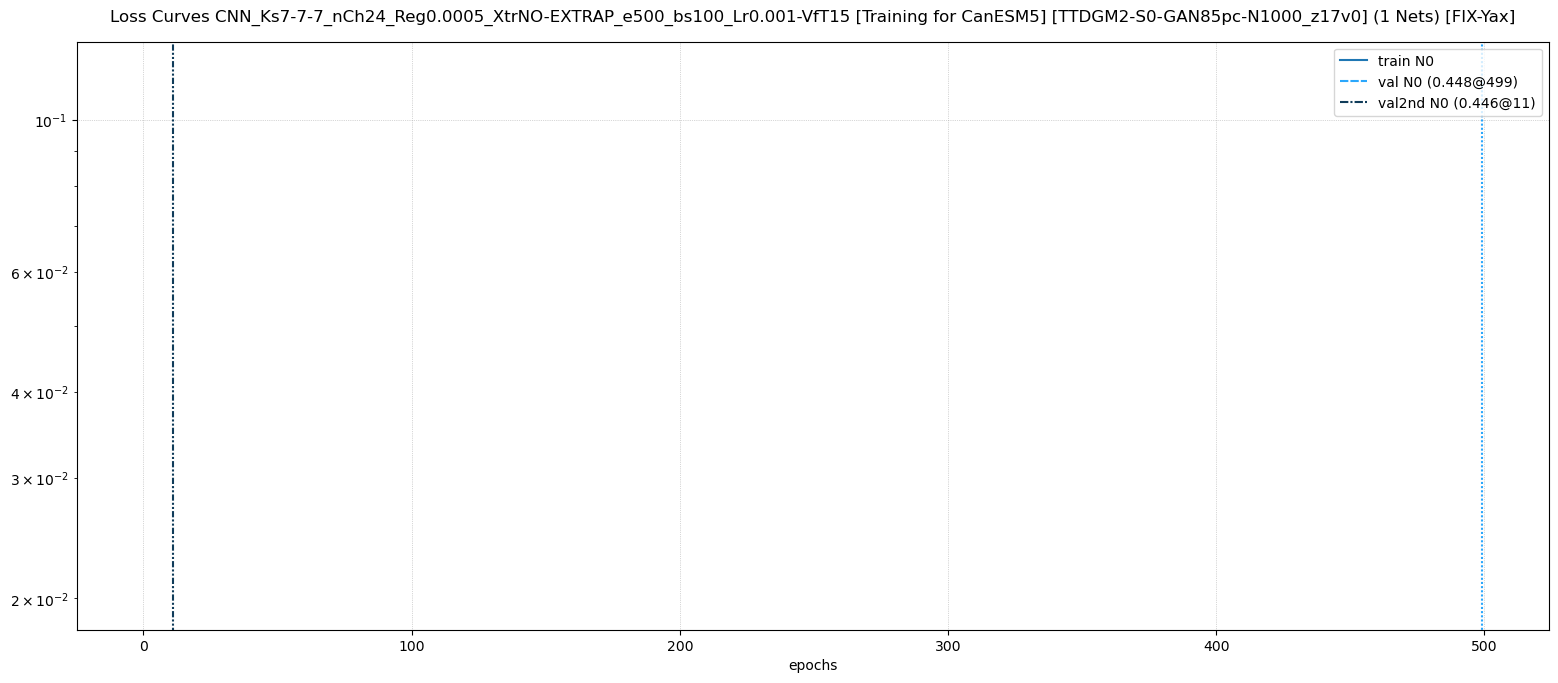


TRAINING INTERMEDIARY TIME: 2023-08-03 15:52:10.526210


------------------------------------------------------------------------------------------------------------------------------------
Training case 1) 'e500_bs100_Lr0.001-VfT15' for modele 2/4)'FGOALS-g3' (it goes to Validation set, training with others)

Training: 1 NNets, Batch Size: 100, Nb Epochs= 500, Learning Rate: 0.0005
Case Train suffix ..... 'e500_bs100_Lr0.001-VfT15'
Case Output dir base .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'

Validation is 15.0% part of 'index_for_train' Train data:
 - TRAIN set has 9350 patterns
 - VAL set has 1650 patterns
 - VAL 2nd set has 1000 patterns
n_to_add: 9
size(NAT): torch.Size([12000, 165])
lenDS: 115 , n_to_add: 9
Repertoire de sortie du cas: ./data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Training-for-mod_FGOALS-g3
Repertoire des figures du cas: /usr/home/habbar/Bureau/data_nc/Figs/out_

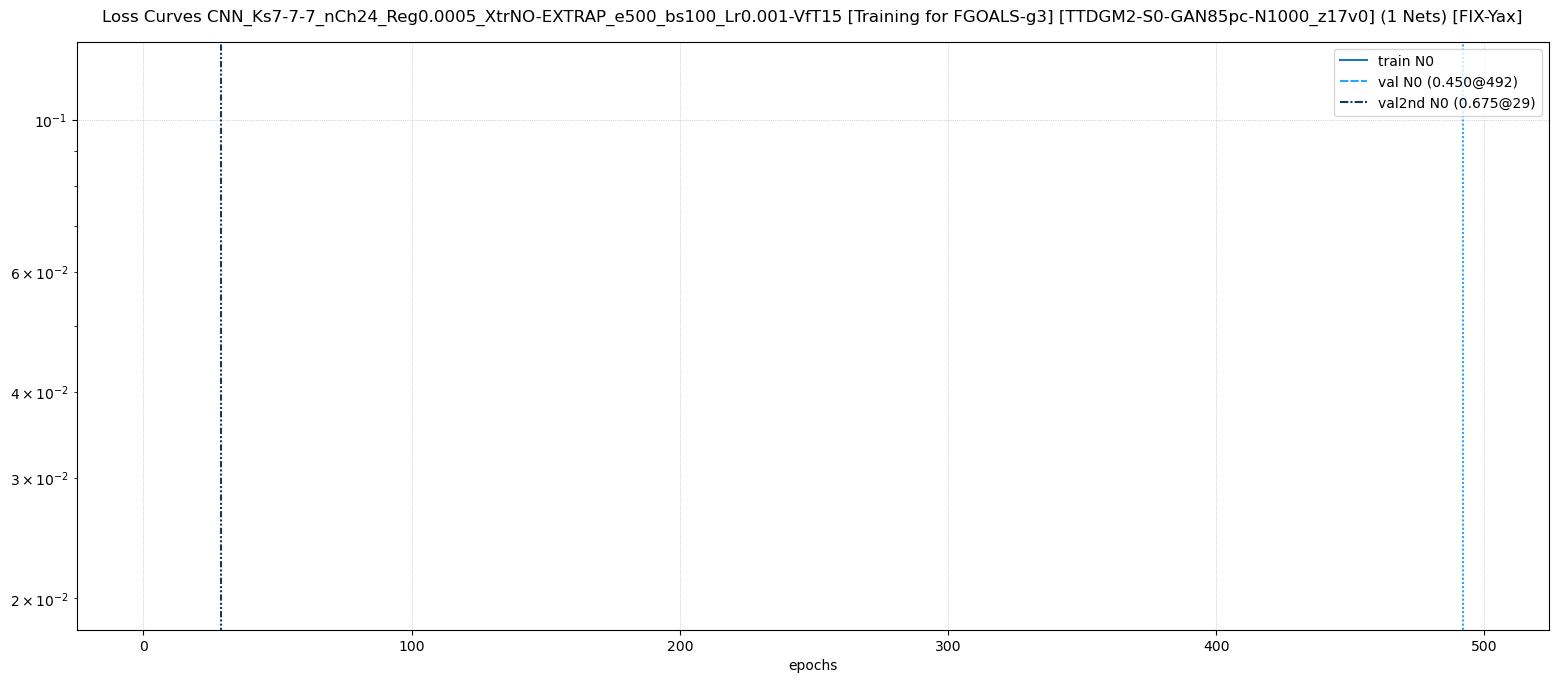


TRAINING INTERMEDIARY TIME: 2023-08-03 15:52:11.028887


------------------------------------------------------------------------------------------------------------------------------------
Training case 1) 'e500_bs100_Lr0.001-VfT15' for modele 3/4)'HadGEM3-GC31-LL' (it goes to Validation set, training with others)

Training: 1 NNets, Batch Size: 100, Nb Epochs= 500, Learning Rate: 0.0005
Case Train suffix ..... 'e500_bs100_Lr0.001-VfT15'
Case Output dir base .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'

Validation is 15.0% part of 'index_for_train' Train data:
 - TRAIN set has 9350 patterns
 - VAL set has 1650 patterns
 - VAL 2nd set has 1000 patterns
n_to_add: 9
size(NAT): torch.Size([12000, 165])
lenDS: 115 , n_to_add: 9
Repertoire de sortie du cas: ./data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Training-for-mod_HadGEM3-GC31-LL
Repertoire des figures du cas: /usr/home/habbar/Bureau/data_

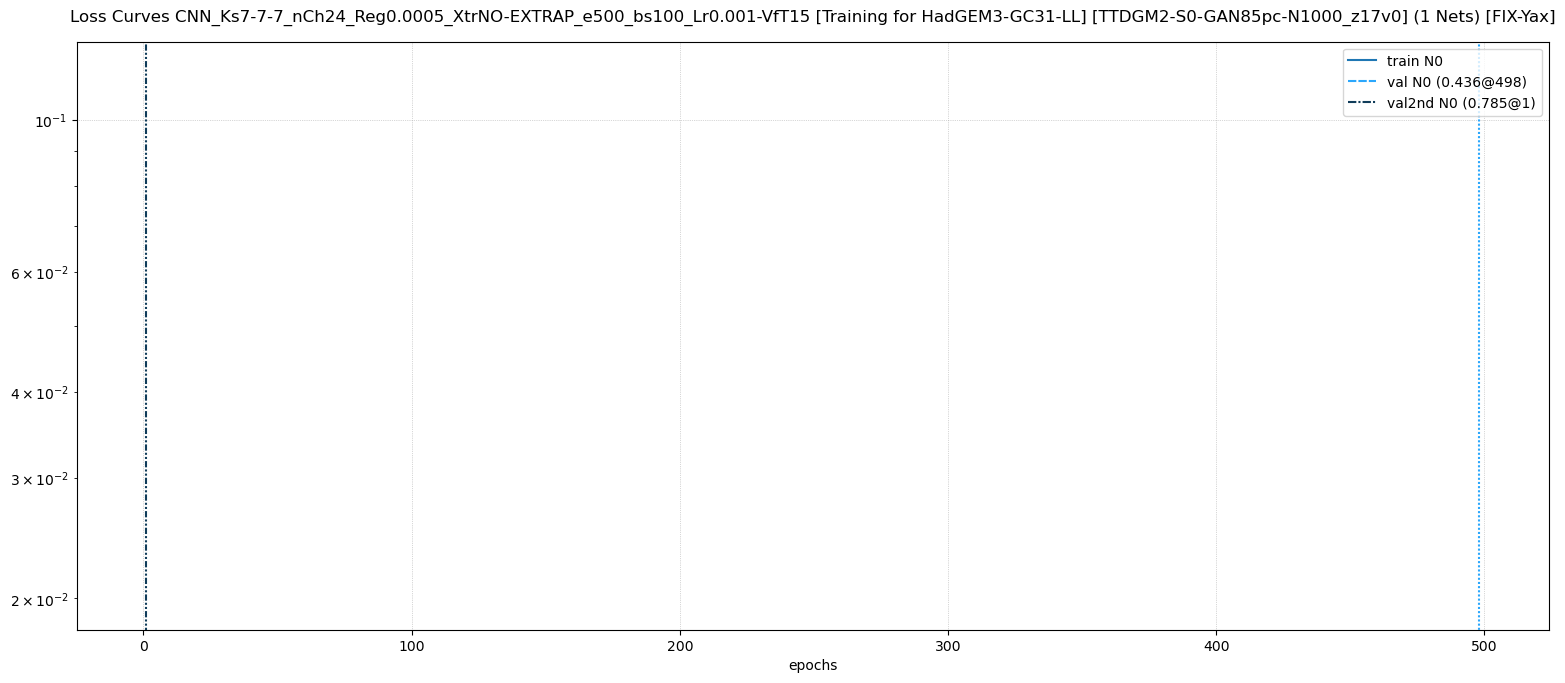


TRAINING INTERMEDIARY TIME: 2023-08-03 15:52:11.515702


------------------------------------------------------------------------------------------------------------------------------------
Training case 1) 'e500_bs100_Lr0.001-VfT15' for modele 4/4)'IPSL-CM6A-LR' (it goes to Validation set, training with others)

Training: 1 NNets, Batch Size: 100, Nb Epochs= 500, Learning Rate: 0.0005
Case Train suffix ..... 'e500_bs100_Lr0.001-VfT15'
Case Output dir base .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'

Validation is 15.0% part of 'index_for_train' Train data:
 - TRAIN set has 9350 patterns
 - VAL set has 1650 patterns
 - VAL 2nd set has 1000 patterns
n_to_add: 9
size(NAT): torch.Size([12000, 165])
lenDS: 115 , n_to_add: 9
Repertoire de sortie du cas: ./data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Training-for-mod_IPSL-CM6A-LR
Repertoire des figures du cas: /usr/home/habbar/Bureau/data_nc/Fig

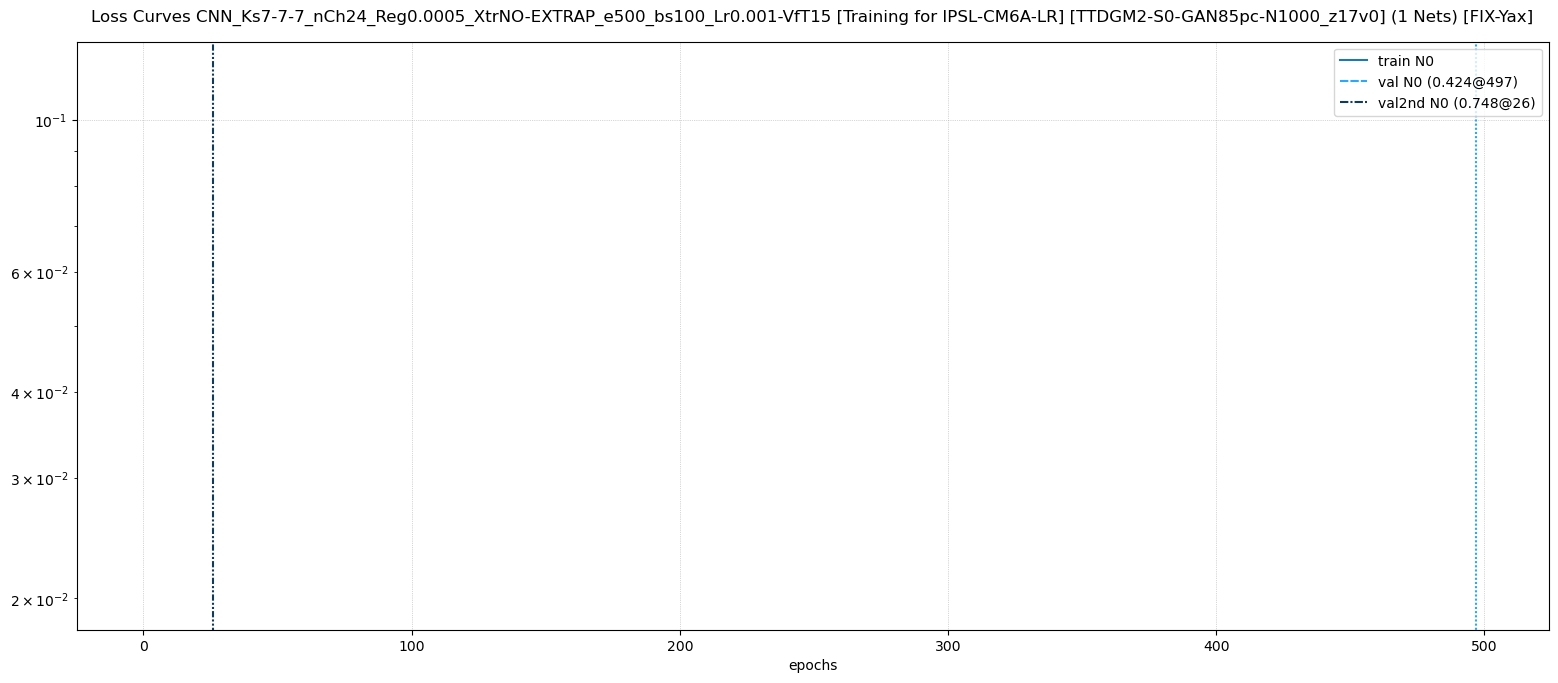


TRAINING INTERMEDIARY TIME: 2023-08-03 15:52:12.050421

<train_procedure done>


TRAINING START TIME at 2023-08-03 15:52:09.835394
            and END at 2023-08-03 15:52:12.050463



In [9]:
#%%time

# train_procedure arguments and options:
# -------------------------------------
#  data_gener_method, train_set_label, do_train=False, test_set_label=None,
#  train_case_extra_label=None, models_to_train=None,
#  train_with_all=False,
#  epochs=100, ksizes=[7,7,7], lr=0.001,
#  batch_size=100, channel_size=24, regul=0.0005, extrap="no-extrap", n_nnets=1,
#  lp_nathist_filtering=False, lp_nathist_filtering_dictionary=None,
#  lp_nathist_filtering_dic_file='lp_nat_and_hist_filtering_param_dictionary.p',
#  seed_before_training=0, log_scale_fig_loss=True, normalization_ok=False,
#  val_part_of_train_ok = False, val_part_of_train_fraction = 0.15,
#  data_in_dir=None, data_out_dir=None, figs_dir=None, plot_loss_figs=True, save_loss_figs=True,
#  local_nb_label="train_procedure", fig_ext='png',
#  figs_defaults={'dpi':300, 'facecolor':'w', 'edgecolor':'w', 'format':'png'},
#  verbose=False,

base_cases_list, sub_cases_list, best_loss_list = train_procedure (data_gener_method, train_set_label, seed_before_training=seed_before_training,
                                                   train_case_extra_label=local_train_extra_label, models_to_train=models_to_train,
                                                   train_with_all=do_train_with_all_models_flg,
                                                   data_in_dir=data_dir,
                                                   epochs=epochs, n_nnets=n_nnets, batch_size=batch_size,
                                                   ksizes=kernel_sizes, channel_size=channel_sizes, lr=learning_rate,
                                                   val_part_of_train_ok = val_part_of_train_ok, val_part_of_train_fraction=val_part_of_train_fraction,
                                                   lp_nathist_filtering=do_try_lp_nathist_filtering, lp_nathist_filtering_dictionary=lp_nathist_filtering_dic,
                                                   figs_dir=figs_dir, plot_loss_figs=plot_loss_figs, save_loss_figs = True, loss_limits = loss_y_limits,
                                                   local_nb_label=local_nb_label,
                                                   do_train=True,
                                                   #default_device='gpu', ngpu=1,
                                                   default_device='cpu',
                                                   verbose=verbose,
                                                  )

In [10]:
print(f"{'%'*132}\n% Cases trained:")
for icas,(cas,scas) in enumerate(zip(base_cases_list, sub_cases_list)):
    print(f"%   - Base case({icas}) .. '{cas}'")
    print(f"%     sub-case ...... '{scas}'")
print(f"{'%'*132}")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% Cases trained:
%   - Base case(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'
%     sub-case ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15'
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


### Test

In [11]:
load_best_val_ok = True
#load_best_val_ok = False

#load_best_val2nd_ok = True   # Drive testing, no matter the value of 'load_best_val_ok' 
load_best_val2nd_ok = False  # if FALSE then 'load_best_val_ok' drives testing ...

In [12]:
plot_loss_curves_ok = True
#plot_loss_curves_ok = False

log_scale_fig_loss = True

#errorlimits_percent = 0.9
errorlimits_percent = None

test_set_prefix = 'test' # a modifier 
# test_set_prefix = 'train'
#test_set_prefix = 'inversion'  # PAS ENCORE INPLEMENTE

do_test_models = True
#do_test_models = False

#do_test_table_all_models = True
do_test_table_all_models = False

plot_output_uniq_HIST_profile_ok = True
#plot_output_uniq_HIST_profile_ok = False
plot_x_forcings_ok = True
#plot_x_forcings_ok = False
pouht_errorlimits_percent = errorlimits_percent

plot_mean_output_by_mod_on_HIST_profile_ok = True
#plot_mean_output_by_mod_on_HIST_profile_ok = False
pmobm_forcings_as_df = True
#pmobm_forcings_as_df = False
pmobm_show_x_all_forcings = True # a modifier 
pmobm_show_x_forcings = True  # a modifier 
pmobm_errorbars_on_pred = True
pmobm_errorlimits_percent = errorlimits_percent
pmobm_plot_forc_shaded_region = True   # if True fill_between, if False errorbars ...
pmobm_plot_pred_shaded_region = True   # if True fill_between, if False errorbars ...

if models_to_train is not None:
    models_to_test = models_to_train
else:
    models_to_test = None  # i.e: all models !


# inherit Training parameters
trained_with_all = do_train_with_all_models_flg

if trained_with_all:
    sample_model = models_to_train_with_all
    
    models_to_test_and_plot = model_names = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
    models_to_test_and_plot = model_names = ['IPSL-CM6A-LR']
    #models_to_test_and_plot = ['IPSL-CM6A-LR', 'CanESM5', 'MIROC6']
    #models_to_test_and_plot = None

else:
    sample_model = None
    models_to_test_and_plot = None

print('models_to_test_and_plot:',models_to_test_and_plot)

models_to_test_and_plot: None


In [13]:
if False:  # valeurs par defaut
    no_print_tables_test_proc = False
    force_write_loss_curves = False
    force_write_test_proc = False
    force_write_test_all_mod = False
    force_write_mse_figs = False
    force_plotandsave_uniq_H_profils = False

else:     # to force re-writing results
    no_print_tables_test_proc = True
    force_write_loss_curves = True
    force_write_test_proc = True
    force_write_test_all_mod = True
    force_write_mse_figs = True
    force_plotandsave_uniq_H_profils = True

#force_plotandsave_uniq_H_profils = True
#force_write_test_all_mod = True

no_print_tables_test_proc = True
#force_write_mse_figs = True

#hist_t_limits = [-0.5, 1.6]   # plots Y axis fixed limits for HIST profils only
hist_t_limits = None

#all_forcings_t_limits = [-1.6, 2.52]   # plots Y axis fixed limits for all Forcings profils
#all_forcings_t_limits = [-10., 10.]   # plots Y axis fixed limits for all Forcings profils
all_forcings_t_limits = None

if plot_x_forcings_ok :
    local_hist_t_limits = all_forcings_t_limits
else:
    local_hist_t_limits = hist_t_limits
    
save_figs_stat = True
do_stat_test = True

In [14]:
from specific_nn_tools_pl import Net

if do_test_experiences :

    # particular case for Testing inversion data set
    #if test_set_prefix == 'inversion':
    #    another_label_to_test = inversion_suffix
    #else:
    another_label_to_test = None 
    
    print("\n# Testing Trained Cases:\n")
    for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
        print(f"\n{'#'*132}#\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
        print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

        ### Plotting (again) Training Loss curves

        if plot_loss_curves_ok :
            if do_try_lp_nathist_filtering :
                loss_min_limit,loss_max_limit = 0.006,0.15
            else:
                loss_min_limit,loss_max_limit = 0.006,0.15
                #loss_min_limit,loss_max_limit = 0.015,0.15

            tstp.plot_loss_curves(base_case_to_explore, sub_case_to_explore, 
                                  models_to_plot=models_to_test,
                                  loss_limits=loss_y_limits,
                                  #save_also_free_fig=False,
                                  save_also_free_fig=True,
                                  log_scale=log_scale_fig_loss, figs_dir=figs_dir,
                                  force_plot=force_write_loss_curves,
                                  force_write=force_write_loss_curves,
                                  verbose=verbose,
                                  )
        else:
            print("\n ** plot loss curves not activated **\n")


        ### Test procedure for all models & all nnets

        if do_test_models :
            #models_to_test = [ 'ACCESS-ESM1-5' ]

            tstp.test_procedure(base_case_to_explore, sub_case_to_explore,
                                set_prefix_to_test=test_set_prefix,
                                data_in_dir=data_dir,
                                #another_label_to_use=another_label_to_test,
                                models_to_test=models_to_test_and_plot,
                                load_best_val=load_best_val_ok,
                                load_best_val2nd=load_best_val2nd_ok,
                                no_print_tables=no_print_tables_test_proc,
                                force_write=force_write_test_proc,
                                verbose=verbose)
        else:
            print(f"\n ** 'do_test_models' is not allowed **\n")


        ### Table MSE and RMSE all models & all nnets

        if do_test_table_all_models :
            # models_to_test = [ 'ACCESS-ESM1-5' ]

            return_test_table_all_models = tstp.build_test_table_all_models(base_case_to_explore, sub_case_to_explore,
                                                                            trained_with_all=trained_with_all, sample_model=sample_model,
                                                                            models_to_test=models_to_test_and_plot,
                                                                            set_prefix_to_test=test_set_prefix, 
                                                                            load_best_val=load_best_val_ok,
                                                                            load_best_val2nd=load_best_val2nd_ok,
                                                                            force_write=force_write_test_all_mod,
                                                                            verbose=verbose)
        else:
            print(f"\n ** 'do_test_table_all_models' is not allowed **\n")
                    

        if plot_output_uniq_HIST_profile_ok :
            #plot_together_uniq_HIST_output(base_case_to_explore, sub_case_to_explore,
            #                               figs_dir=figs_dir, save_figs=save_figs,
            #                               force_plot=True, force_write=True,
            #                               verbose=False,
            #                              )
            tstp.plot_output_uniq_HIST_profils(base_case_to_explore, sub_case_to_explore,
                                                trained_with_all=trained_with_all, sample_model=sample_model,
                                                models_to_plot=models_to_test_and_plot,
                                                set_prefix_to_test=test_set_prefix,
                                                show_x_forcings=plot_x_forcings_ok,
                                                errorlimits_percent=pouht_errorlimits_percent,
                                                figs_dir=figs_dir, save_figs=save_figs,
                                                load_best_val=load_best_val_ok,
                                                load_best_val2nd=load_best_val2nd_ok,
                                                t_limits=local_hist_t_limits,
                                                force_plot=force_plotandsave_uniq_H_profils,
                                                force_write=force_plotandsave_uniq_H_profils,
                                                verbose=verbose,
                                              )

        else:
            print(f"\n ** 'plot_output_uniq_HIST_profile_ok' is not allowed **\n")


        if plot_mean_output_by_mod_on_HIST_profile_ok :
            #plot_together_uniq_HIST_output(base_case_to_explore, sub_case_to_explore,
            #                               figs_dir=figs_dir, save_figs=save_figs,
            #                               force_plot=True, force_write=True,
            #                               verbose=False,
            #                              )
            tstp.plot_mean_output_by_mod_on_HIST_profils(base_case_to_explore, sub_case_to_explore,
                                                          trained_with_all=trained_with_all, sample_model=sample_model,
                                                          models_to_plot=models_to_test_and_plot,
                                                          source_dirname=data_dir, save_figs_stat = save_figs_stat,
                                                          do_stat_test = do_stat_test,
                                                          set_prefix_to_test=test_set_prefix, 
                                                          show_x_all_forcings=pmobm_show_x_all_forcings,
                                                          show_x_forcings=pmobm_show_x_forcings,
                                                          plot_forc_shaded_region=pmobm_plot_forc_shaded_region,
                                                          plot_pred_shaded_region=pmobm_plot_pred_shaded_region,
                                                          errorlimits_percent=pmobm_errorlimits_percent,
                                                          forcings_as_df=pmobm_forcings_as_df,
                                                          figs_dir=figs_dir, save_figs=save_figs,
                                                          load_best_val=load_best_val_ok,
                                                          load_best_val2nd=load_best_val2nd_ok,
                                                          t_limits=local_hist_t_limits,
                                                          force_plot=force_plotandsave_uniq_H_profils,
                                                          force_write=force_plotandsave_uniq_H_profils,
                                                          errorbars_on_pred=pmobm_errorbars_on_pred,
                                                          verbose=verbose,
                                                        )

        else:
            print(f"\n ** 'plot_mean_output_by_mod_on_HIST_profile_ok' is not allowed **\n")

else:
    tmp_msg = f"'do_test_experiences' is not allowed"
    print(f"\n {'*'*80}\n ** {tmp_msg:^74} **\n {'*'*80}\n")


 ********************************************************************************
 **                    'do_test_experiences' is not allowed                    **
 ********************************************************************************



### Inversion

In [15]:
do_inverse_models = True
#do_inverse_models = False

# conditions for choosing profiles for inverson. By default NO Selection (nbest_to_choose = None)
nbest_to_choose = None        # give max number of profiles to invert for each model
choose_profiles_by_proximity_criterion = 'rmse' # method, for instance 'rmse' or 'dist' (quite the same)
period_to_choose = None       # tuple having initial-year and end-year (end-year can be -1), to be used as period to choose nearest hist profiles
#period_to_choose = (1965, -1)

take_xo_for_inversion_cost = False    # default #take_xo_for_cost=take_xo_for_inversion_cost 
#take_xo_for_inversion_cost = True

do_mean_of_each_model_for_invert = False   # averaging individual forcings, by model, for inversion
#do_mean_of_each_model_for_invert = True  # invert individual forcings (Normal case)

add_mean_of_all_for_invert = False # don't add mean of all forcings to invert
#add_mean_of_all_for_invert = True   # add the mean of all forcings in inversion

# ----------------------------------------------------------------------------------------------------
# Flags to execute or not some procedures producing results or figures after inversion done
# ----------------------------------------------------------------------------------------------------

plot_averaged_inv_all_forcings_by_net_ok = True
#plot_averaged_inv_all_forcings_by_net_ok = False

inv_forc_shaded_region=True #C'est pour ploter les barres d'erreur des donnees des modeles 
paiafbn_hist_shaded_region=True #C'est pour ploter les barres d'erreur des donnees hist
inv_hist_shaded_region=False #C'est pour ploter les barres d'erreur des donnees hist
ini_forc_shaded_region=False  #C'est pour ne pas ploter les barres d'erreur des donnees des modeles 
inv_filt_forc_shaded_region=False #C'est pour ne pas ploter les barres d'erreur des donnees des modeles filtrées

paiafbn_plot_forc_shaded_region = True   # if True fill_between, if False errorbars ...
paiafbn_plot_src4inv_forc_shaded_region = True
paiafbn_plot_src4inv_shaded_region = False
paiafbn_errorlimits_percent = errorlimits_percent
#--------------- autorise ou non l'affichage des Forcage source pour le modele en cours.
#--------------- Apparait comme [+Xsrc] dans le titre, zt '_+XsrcMod]' dans le nom de la figure. 
paiafbn_plot_src_Model_forc = True
#paiafbn_plot_src_Model_forc = False                                                     
#--------------- autorise ou non l'affichage des Forcage initiaux pour l'inversion en cours.
#--------------- Apparait comme [+Xini] dans le titre, et '_+XiniMod' dans le nom de la figure. 
#paiafbn_plot_ini_forc = True
paiafbn_plot_ini_forc = False
#---------------
#--------------- autorise ou non l'affichage des Forcage X inversés par l'inversion en cours.
#--------------- Apparait comme [+Xinv] dans le titre, et '_+XinvMod' dans le nom de la figure. 
paiafbn_plot_inv_forc = True
#paiafbn_plot_inv_forc = False
#paiafbn_plot_inv_filt_forc = True
paiafbn_plot_inv_filt_forc = False

paiafbn_plot_hist2inv = True            # if True plot HIST2INV
paiafbn_hist2inv_shaded_region = False   # if True plot HIST2INV with shaded region

paiafbn_plot_mean_other_mod = False

paiafbn_plot_src4inv_hist = False
paiafbn_plot_src4inv_shaded_hist = False

#one_ax_by_forcing=True
one_ax_by_forcing=False

if models_to_train is not None:
    models_for_invert_and_plot = models_to_train
else:
    models_for_invert_and_plot = None  # i.e: all models !


#hist_t_limits = [-0.5, 1.6]   # plots Y axis fixed limits for HIST profils
hist_t_limits = None

#all_forcings_t_limits = [-1.6, 2.52]   # plots Y axis fixed limits for HIST profils
#all_forcings_t_limits = [-10., 10.]   # plots Y axis fixed limits for HIST profils
all_forcings_t_limits = [-4, 5]

# default values :
#    tmp_alpha=0.1; tmp_lr_opt=0.1; tmp_n_iter=200; tmp_delta_loss_limit=1e-7; tmp_patience=0
local_inv_n_iter = 600
local_inv_lr_reg = 0  # 0.01  # B
local_inv_alpha  = 0.1   # A
local_inv_lr_opt = 0.01   # learning rate optimizer
local_inv_regula = None    # C = 0.1

# inherit Training parameters
trained_with_all = do_train_with_all_models_flg

if trained_with_all:
    sample_model = models_to_train_with_all
#trained_with_all = False
#sample_model = None

number_of_multiobs=None
multiobs_choice_method='random'
multiobs_random_seed=0  #10 
rmse_start_year = 1900      # Pour le calcul du RMSE à partir de cette année

In [16]:
'''if trained_with_all :
    if True:
        models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
        # models_for_invert_and_plot = ['CNRM-CM6-1']
        #[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',
        #                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
        #                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]
        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3']
        # models_for_invert_and_plot += ['OBS']
        models_for_invert_and_plot = ['HadCRUT']
        # models_for_invert_and_plot += ['HadCRUT200']
        
        
        # number_of_multiobs=2
        # nbest_to_choose=150
        # period_to_choose=(1965,-1)

    else:
        models_for_invert_and_plot = ['IPSL-CM6A-LR']
        #models_for_invert_and_plot = ['CanESM5']
        #models_for_invert_and_plot = ['MIROC6']
        #models_for_invert_and_plot = ['IPSL-CM6A-LR', 'CanESM5', 'MIROC6', 'OBS']
        
        #models_for_invert_and_plot = ['OBS']
        
        #models_for_invert_and_plot = ['HadCRUT']
        #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
        
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; 
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
        
        models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; 
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year

else:
    models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                  'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                  'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                  'NorESM2-LM']
    models_for_invert_and_plot += ['OBS']
    models_for_invert_and_plot += ['HadCRUT'] #; nbest_to_choose=50
    #models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1
    #models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150

    #number_of_multiobs=1
    #number_of_multiobs=1; nbest_to_choose=150
    #number_of_multiobs=1; nbest_to_choose=150; period_to_choose=(1965,-1)

    #[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',
    #                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
    #                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]
    
    #models_for_invert_and_plot = ['OBS'];
    #models_for_invert_and_plot = ['OBS']; nbest_to_choose=150
    
    #models_for_invert_and_plot = ['HadCRUT'];
    #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150
    #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
    
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year


do_try_lp_obs_filtering = do_try_lp_nathist_filtering
#do_try_lp_obs_filtering = True
#do_try_lp_obs_filtering = False
if do_try_lp_obs_filtering:
    # dictionary having the arguments for the scipy.signal.butter() function
    if type(lp_nathist_filtering_dic) is dict :
        lp_obs_filtering_dic = lp_nathist_filtering_dic
    else:
        lp_obs_filtering_dic = { 'n':4, 'Wn':[1./10.], 'btype':'lowpass' };
else:
    lp_obs_filtering_dic = None'''

"if trained_with_all :\n    if True:\n        models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', \n                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', \n                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',\n                                             'NorESM2-LM']\n        # models_for_invert_and_plot = ['CNRM-CM6-1']\n        #[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',\n        #                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',\n        #                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]\n        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3']\n        # models_for_invert_and_plot += ['OBS']\n        models_for_invert_and_plot = ['HadCRUT']\n        # models_for_invert_and_plot += ['HadCRUT200']\n        \n        \n        # number_of_multiobs=2\n        # nbest_t

In [17]:
'''models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                    'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                    'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                    'NorESM2-LM']'''

models_for_invert_and_plot = ['CanESM5', 'FGOALS-g3', 
                              'HadGEM3-GC31-LL', 'IPSL-CM6A-LR']

#models_for_invert_and_plot += ['OBS']
#models_for_invert_and_plot += ['HadCRUT']
#models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1
#models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150

#number_of_multiobs=1
#number_of_multiobs=1; nbest_to_choose=150
#number_of_multiobs=1; nbest_to_choose=150; period_to_choose=(1965,-1)

#[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',
#                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
#                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]

#models_for_invert_and_plot = ['OBS'];
#models_for_invert_and_plot = ['OBS']; nbest_to_choose=150

#models_for_invert_and_plot = ['HadCRUT']
#models_for_invert_and_plot = ['HadCRUT'];

nbest_to_choose = 150
number_of_multiobs = 1
#models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year

#models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10
#models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150
#models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year

do_try_lp_obs_filtering = do_try_lp_nathist_filtering
#do_try_lp_obs_filtering = True
#do_try_lp_obs_filtering = False
if do_try_lp_obs_filtering:
    # dictionary having the arguments for the scipy.signal.butter() function
    if type(lp_nathist_filtering_dic) is dict :
        lp_obs_filtering_dic = lp_nathist_filtering_dic
    else:
        lp_obs_filtering_dic = {'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
else:
    lp_obs_filtering_dic = None

if True:  # valeurs par defaut
    force_inverse_procedure = False
    force_inverted_hist_profiles = False
    force_average_inverted_profiles = False
    force_ave_inv_all_forc_by_model = False
    force_ave_inv_all_forc_by_net = False
    
else:     # to force re-writing results
    force_inverse_procedure = True
    force_inverted_hist_profiles = True
    force_average_inverted_profiles = True
    force_ave_inv_all_forc_by_model = True
    force_ave_inv_all_forc_by_net = True
    
force_inverse_procedure = True
#force_inverse_procedure = False

force_ave_inv_all_forc_by_net = True


In [18]:
if True:  # valeurs par defaut
    force_inverse_procedure = False
    force_inverted_hist_profiles = False
    force_average_inverted_profiles = False
    force_ave_inv_all_forc_by_model = False
    force_ave_inv_all_forc_by_net = False
    
else:     # to force re-writing results
    force_inverse_procedure = True
    force_inverted_hist_profiles = True
    force_average_inverted_profiles = True
    force_ave_inv_all_forc_by_model = True
    force_ave_inv_all_forc_by_net = True
    
#force_inverse_procedure = True
force_inverse_procedure = False

force_ave_inv_all_forc_by_net = True

In [19]:
#verbose_inv = False
verbose_inv = True

#verbose = False
verbose = True

debug = False
#debug = True
data_out_dir = "/usr/home/habbar/Bureau/data_nc/data_out"

if do_inversion_experiences :
    print("\n# Inversion procedure for Trained Cases:\n") 
    for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
        print(f"\n{'#'*132}\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
        print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4']
        #models_for_invert_and_plot = [ 'ACCESS-ESM1-5' ]
        #models_for_invert_and_plot = [ 'FGOALS-g3' ]
        #models_for_invert_and_plot = None

        current_inversion_settings_label, \
            current_inv_ssettings_sdir_dic = invp.inversion_procedure(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                                                                      take_xo_for_cost=take_xo_for_inversion_cost,
                                                                       trained_with_all=trained_with_all, sample_model=sample_model,
                                                                       load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok,
                                                                       models_for_inversion=models_for_invert_and_plot,
                                                                       do_mean_of_each_model=do_mean_of_each_model_for_invert,
                                                                       data_in_dir=None, data_out_dir = data_out_dir,
                                                                       add_mean_of_all=add_mean_of_all_for_invert,
                                                                       inv_n_iter=local_inv_n_iter, regula = local_inv_regula, inv_lr_reg=local_inv_lr_reg,
                                                                       inv_lr_opt=local_inv_lr_opt, inv_alpha=local_inv_alpha,
                                                                       do_inversion=do_inverse_models,
                                                                       force_inverse=force_inverse_procedure,
                                                                       lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                                                                       number_of_multiobs=number_of_multiobs, multiobs_choice_method=multiobs_choice_method, multiobs_random_seed=multiobs_random_seed,
                                                                       nbest_to_choose=nbest_to_choose, choose_profiles_by_proximity_criterion=choose_profiles_by_proximity_criterion, 
                                                                       period_to_choose=period_to_choose, 
                                                                       # default_device='gpu', ngpu=0,
                                                                       default_device='cpu',
                                                                       verbose_inv=verbose_inv, verbose=verbose, debug=debug)


# Inversion procedure for Trained Cases:


####################################################################################################################################
#  - Base case to explore(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'
#    sub-case to explore ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15'
Data directory found: '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17'

Retrieving parameters from specified base case to explore 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet':
 - Number of CNN trained found in label: 1
 - Data generation method: TTDGM2
 - Seed value for initializing Random sequence : 0
 - Franction of G.A.N. (GHG, AER, NAT) data for Training : 85
 - Data and Training Label: TTDGM2-S0-GAN85pc-N1000_z17v0
 - Associated Test Label: TTDGM2-S0-GAN15pc-NMx1000_z17v0
 - Low-pass NAT anf HIST filtering: False
 - Number of NNets: 1
 - Data and Training set Llabel: TTDGM2-S0-GAN85pc

ACCESS-ESM1-5  BCC-CSM2-MR     CESM2  CNRM-CM6-1   CanESM5  FGOALS-g3  \
1850      -0.045125    -0.076207 -0.112786   -0.102095 -0.086431  -0.159567   
1851       0.202195     0.211494  0.161679    0.193729  0.205785   0.135351   
1852      -0.110520    -0.076050 -0.032429   -0.012873 -0.062377  -0.112722   
1853       0.002161    -0.082622 -0.135535   -0.048068 -0.085038  -0.119140   
1854       0.114869     0.041506  0.008594    0.068181  0.074705   0.007603   
...             ...          ...       ...         ...       ...        ...   
2010       1.581788     1.618951  1.686201    1.603787  1.521284   1.609156   
2011       1.770551     1.753216  1.838353    1.793662  1.698381   1.750594   
2012       1.669639     1.657410  1.735453    1.756505  1.618747   1.691117   
2013       1.934342     1.843144  1.924754    1.921576  1.830602   1.868273   
2014       1.868320     1.826907  1.904282    1.854286  1.794025   1.791919   

      GISS-E2-1-G  HadGEM3-GC31-LL  IPSL-CM6A-LR    MIROC6  MRI-ESM2-0  \
1850    -0.097694        -0.102479     -0.088598  0.009594   -0.118777   
1851     0.184588         0.212168      0.204783  0.127613    0.205663   
1852    -0.057493        -0.030644     -0.057066 -0.050100   -0.080894   
1853    -0.102554        -0.112663     -0.076763 -0.153760   -0.135665   
1854     0.074762         0.088231      0.068060  0.068284    0.070429   
...           ...              ...           ...       ...         ...   
2010     1.597005         1.528015      1.592812  1.673645    1.650966   
2011     1.771445         1.683428      1.760087  1.760226    1.800760   
2012     1.739121         1.654008      1.698519  1.717814    1.784546   
2013     1.894155         1.858646      1.907061  1.869703    1.952544   
2014     1.922843         1.811077      1.862433  1.877126    1.931683   

      NorESM2-LM  
1850   -0.102663  
1851    0.166468  
1852   -0.124519  
1853   -0.061702  
1854    0.047608  
...          ...  
2010    1.651226  
2011    1.829883  
2012    1.781871  
2013    1.962532  
2014    1.952905  

[165 rows x 12 columns]

List of Models found loading data (alphabetical order) ... ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']
List of Models for Inversion ............................. ['CanESM5', 'FGOALS-g3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR']
List of Models found in Inversion data ................... ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM']
Currently used device is : cpu

Current case:
   'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15' in folder out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/
single_models_already_trained: ['CanESM5', 'FGOALS-g3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR']

 ------------------------------------------------------------------------------------------------------------------------------------
 -
 - Inversion case

In [20]:
dat_dic11 = gt.load_basic_data_and_gener_df()


Lecture des meta donnees (ALL_sim, liste de modeles, ...) ...

Reading forcing data files ...
 Data 'T_ghg_z17v0.p' -> dim: (103, 165)
0 3
3 6
6 9
9 17
17 67
67 70
70 80
80 84
84 92
92 95
95 100
100 103
 Data 'T_aer_z17v0.p' -> dim: (89, 165)
0 3
3 6
6 8
8 16
16 46
46 49
49 59
59 63
63 71
71 81
81 86
86 89
 Data 'T_nat_z17v0.p' -> dim: (160, 165)
0 3
3 6
6 9
9 17
17 67
67 70
70 90
90 94
94 102
102 152
152 157
157 160
 Data 'T_hist_z17v0.p' -> dim: (256, 165)
0 15
15 18
18 29
29 57
57 122
122 128
128 156
156 161
161 192
192 242
242 253
253 256


In [21]:
dat_dic11.keys()

dict_keys(['label', 'data_dir', 'models', 'forcings', 'forcing_color_dic', 'forcing_color_names_dic', 'forcing_inv_color_dic', 'forcing_inv_color_names_dic', 'forcing_light_color_dic', 'forcing_light_color_names_dic', 'years', 'list_of_df'])

In [22]:
nat_df = dat_dic11['list_of_df'][2]
nat_df.describe()

1850        1851        1852        1853        1854        1855  \
count  160.000000  160.000000  160.000000  160.000000  160.000000  160.000000   
mean     0.000704   -0.009173   -0.050878    0.064738   -0.115266   -0.001002   
std      0.612973    0.632415    0.694578    0.578995    0.686627    0.668834   
min     -2.173913   -1.582054   -1.949543   -1.552976   -1.980432   -1.522368   
25%     -0.339985   -0.444639   -0.511155   -0.328984   -0.518359   -0.530934   
50%      0.012367    0.023239   -0.035924    0.107651   -0.125244   -0.003404   
75%      0.377521    0.483976    0.430115    0.450263    0.254903    0.486334   
max      1.637952    1.358226    2.051818    1.403238    1.692045    1.669328   

             1856        1857        1858        1859        1860        1861  \
count  160.000000  160.000000  160.000000  160.000000  160.000000  160.000000   
mean     0.029895    0.027393    0.015407    0.109021    0.028062   -0.063148   
std      0.691391    0.605720    0.600051    0.631497    0.658899    0.656866   
min     -1.920798   -1.719052   -1.578262   -1.543861   -1.499277   -1.836608   
25%     -0.311045   -0.332277   -0.360152   -0.305928   -0.430158   -0.545028   
50%      0.103624   -0.010814    0.042381    0.099777    0.020232   -0.063024   
75%      0.510443    0.411902    0.388207    0.568162    0.492033    0.422902   
max      2.106351    1.622118    1.441949    2.201343    1.650458    1.523856   

             1862        1863        1864  ...        2000        2001  \
count  160.000000  160.000000  160.000000  ...  160.000000  160.000000   
mean     0.019156   -0.062165   -0.037050  ...   -0.059097   -0.012312   
std      0.637661    0.568569    0.650169  ...    0.623479    0.620724   
min     -1.450429   -2.132775   -2.053987  ...   -1.657740   -1.704478   
25%     -0.404654   -0.429041   -0.396707  ...   -0.465087   -0.443611   
50%     -0.015307    0.031569    0.006227  ...   -0.079422   -0.012695   
75%      0.467696    0.329175    0.392072  ...    0.393808    0.384297   
max      2.026358    1.074047    1.655305  ...    1.348909    1.474331   

             2002        2003        2004        2005        2006        2007  \
count  160.000000  160.000000  160.000000  160.000000  160.000000  160.000000   
mean    -0.070883    0.040548   -0.030342   -0.021825   -0.063259   -0.006031   
std      0.644572    0.717827    0.664320    0.706011    0.633159    0.674357   
min     -1.723383   -2.036800   -1.980129   -2.635534   -2.275518   -1.671169   
25%     -0.493077   -0.451849   -0.453225   -0.417656   -0.454820   -0.516765   
50%     -0.111009    0.115158   -0.082086   -0.000730   -0.053410    0.022387   
75%      0.375037    0.523949    0.319329    0.397785    0.339141    0.478651   
max      2.043399    1.595022    2.098198    1.816269    1.401772    1.487449   

             2008        2009        2010        2011        2012        2013  \
count  160.000000  160.000000  160.000000  160.000000  160.000000  160.000000   
mean     0.017177    0.016721   -0.029855    0.022837   -0.036029    0.006827   
std      0.566297    0.668828    0.638521    0.681770    0.618394    0.632724   
min     -1.442725   -2.181942   -1.847596   -2.249362   -2.414582   -1.840769   
25%     -0.290174   -0.400301   -0.418694   -0.416371   -0.374078   -0.384891   
50%      0.007154    0.024708    0.005148    0.053898    0.015110   -0.016341   
75%      0.359738    0.420066    0.419541    0.470596    0.328431    0.443532   
max      1.669135    1.727050    1.806129    1.631552    1.484950    1.817139   

             2014  
count  160.000000  
mean    -0.063524  
std      0.587864  
min     -1.915398  
25%     -0.488197  
50%     -0.041095  
75%      0.367475  
max      1.578675  

[8 rows x 165 columns]

In [23]:
base_cases_list, sub_cases_list 

(['out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'],
 ['CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15'])

In [24]:
#models_for_invert_and_plot.remove('OBS')
print('models_for_invert_and_plot:- ......',models_for_invert_and_plot)
print('current_inversion_settings_label ..',current_inversion_settings_label)
print('current_inv_ssettings_sdir_dic ....',current_inv_ssettings_sdir_dic)

models_for_invert_and_plot:- ...... ['CanESM5', 'FGOALS-g3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR']
current_inversion_settings_label .. Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0
current_inv_ssettings_sdir_dic .... {'CanESM5': 'SEL1RND-FROM65_best-val-net_XNearest150_yall', 'FGOALS-g3': 'SEL1RND-FROM6_best-val-net_XNearest150_yall', 'HadGEM3-GC31-LL': 'SEL1RND-FROM5_best-val-net_XNearest150_yall', 'IPSL-CM6A-LR': 'SEL1RND-FROM31_best-val-net_XNearest150_yall'}



# Inversion procedure for Trained Cases:


####################################################################################################################################
#  - Base case to explore(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet'
#    sub-case to explore ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15'


Data directory found: '/usr/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17'

Retrieving parameters from specified base case to explore 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet':
 - Number of CNN trained found in label: 1
 - Data generation method: TTDGM2
 - Seed value for initializing Random sequence : 0
 - Franction of G.A.N. (GHG, AER, NAT) data for Training : 85
 - Data and Training Label: TTDGM2-S0-GAN85pc-N1000_z17v0
 - Associated Test Label: TTDGM2-S0-GAN15pc-NMx1000_z17v0
 - Low-pass NAT anf HIST filtering: False
 - Number of NNets: 1
 - Data and Training set Llabel: TTDGM2-S0-GAN85pc-N1000_z17v0
 - Low-pass NAT and HIST filtering: False
 - Applying STD coefficient: <NOT ACTIVATED>

Retrieving parameters from specified sub case to explore 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15':
(a subdirectory of 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet')
 - List of sizes of CNN hidden layers or (kernel sizes): [7, 7

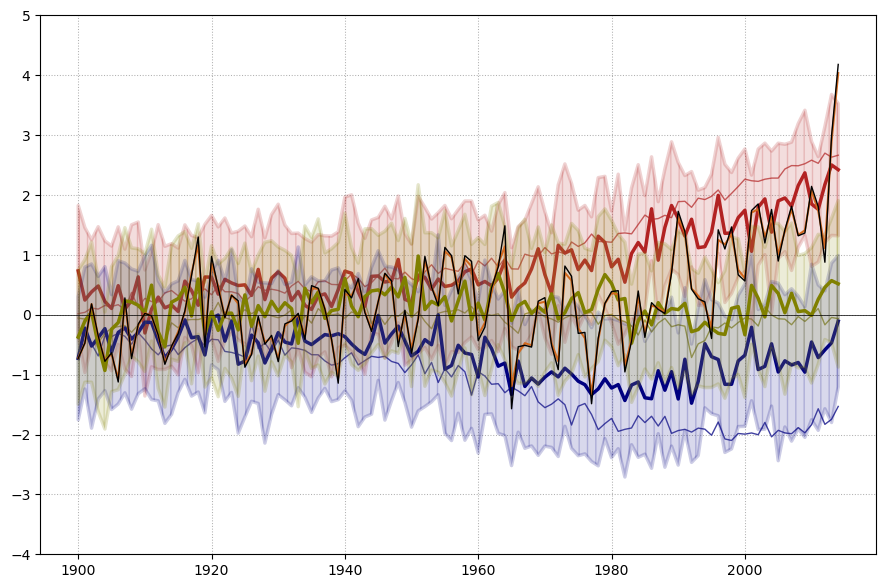

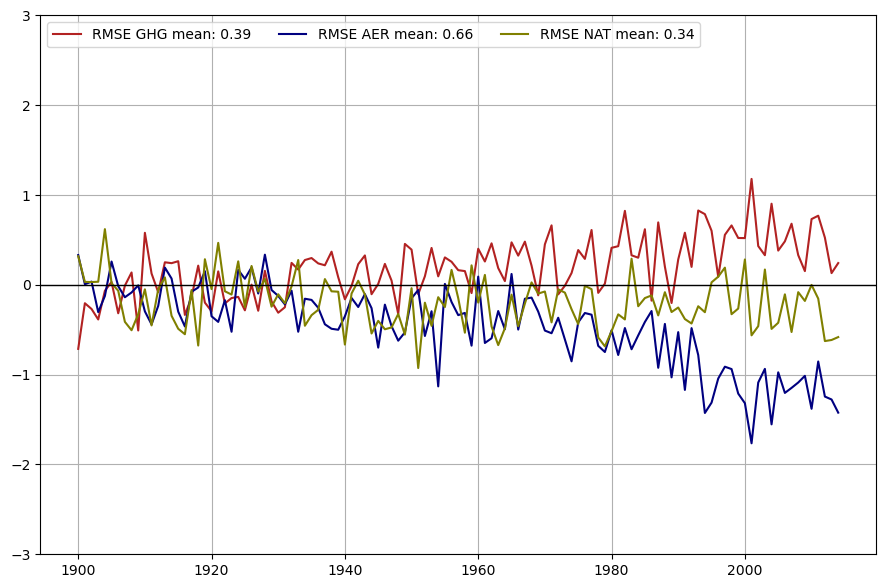

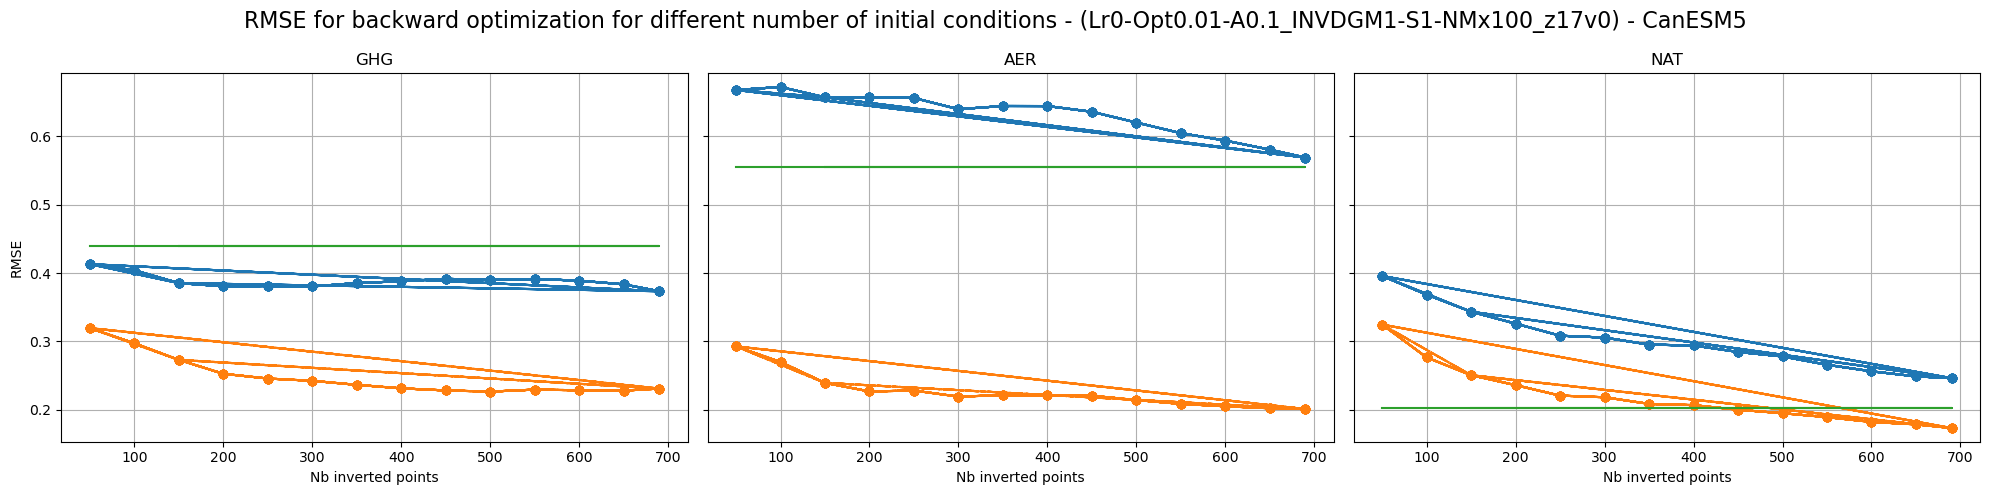

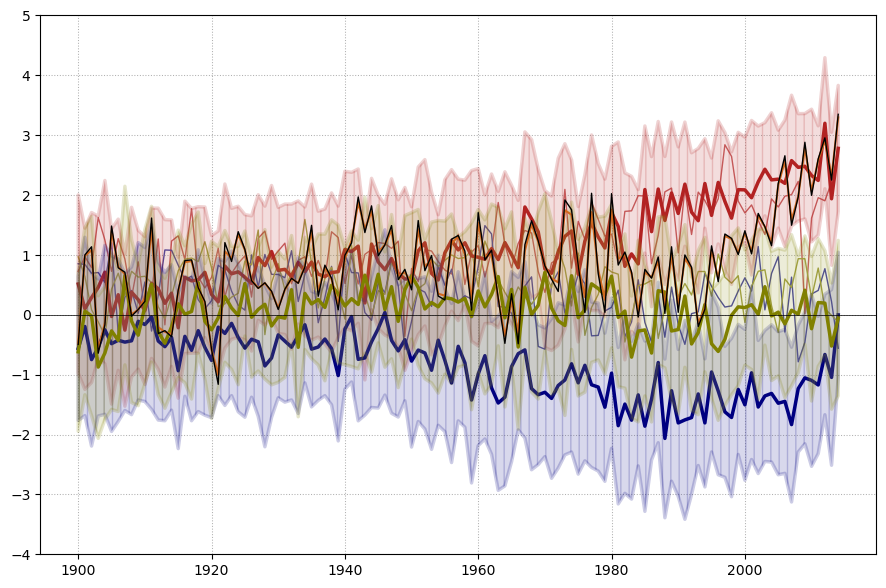

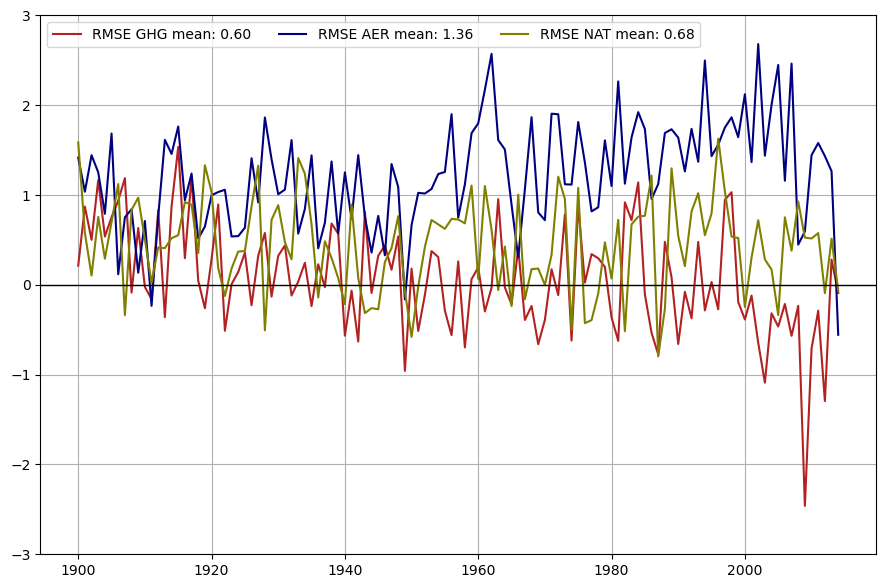

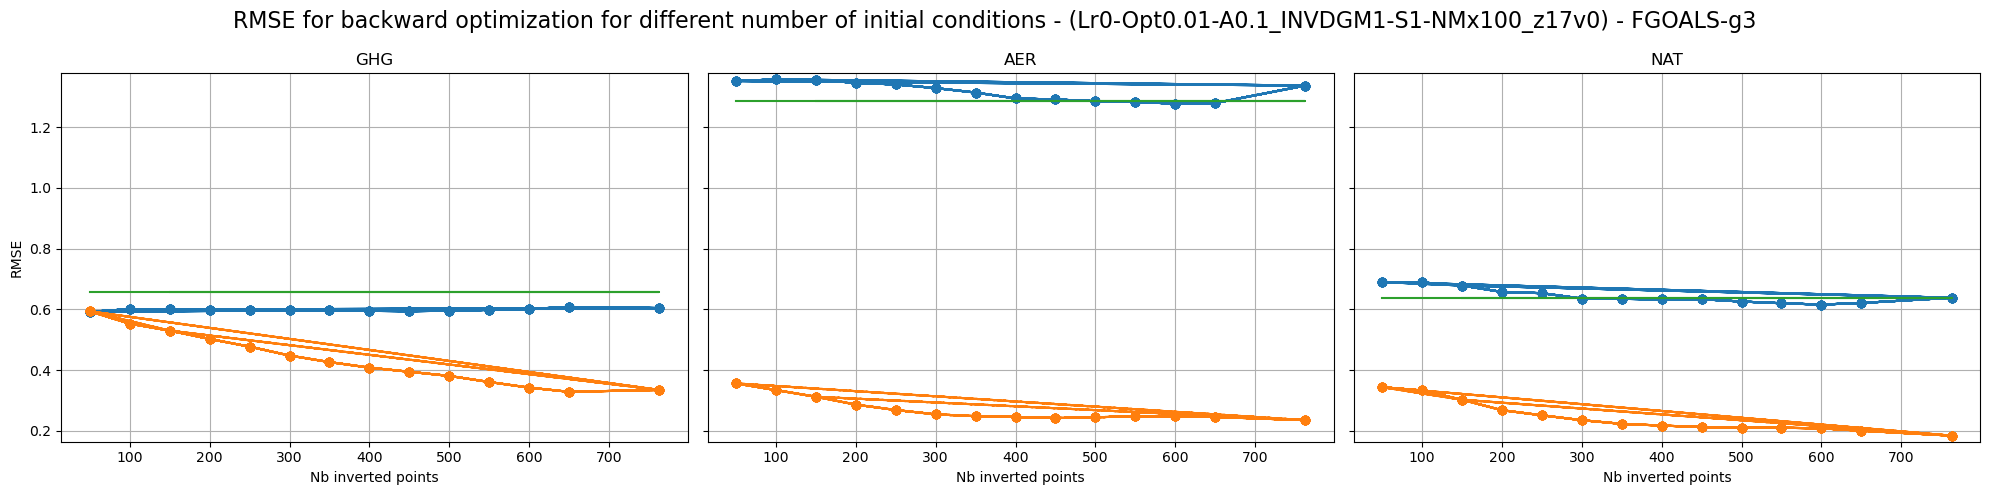

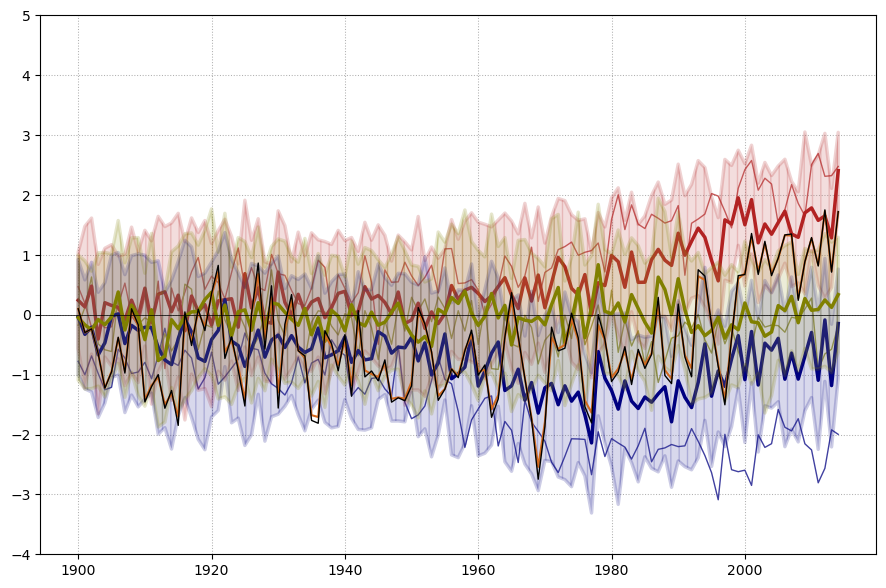

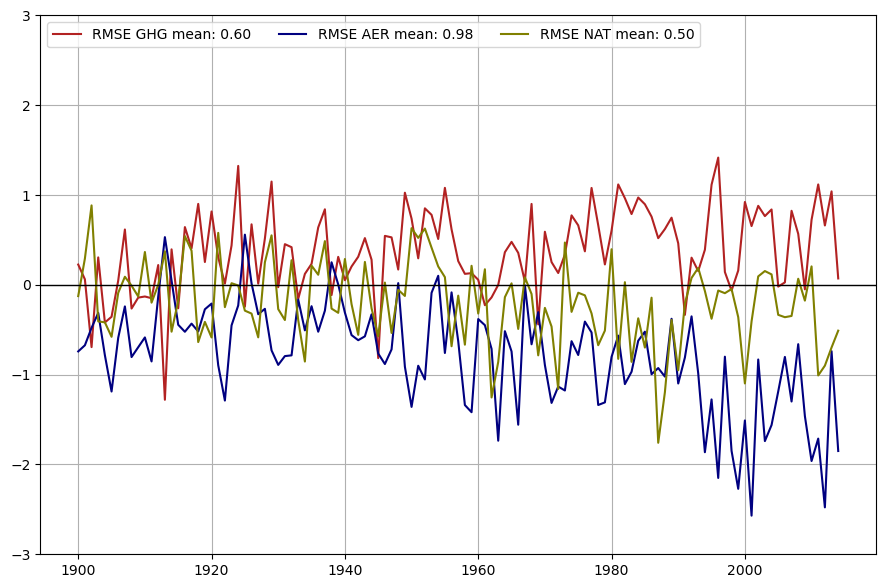

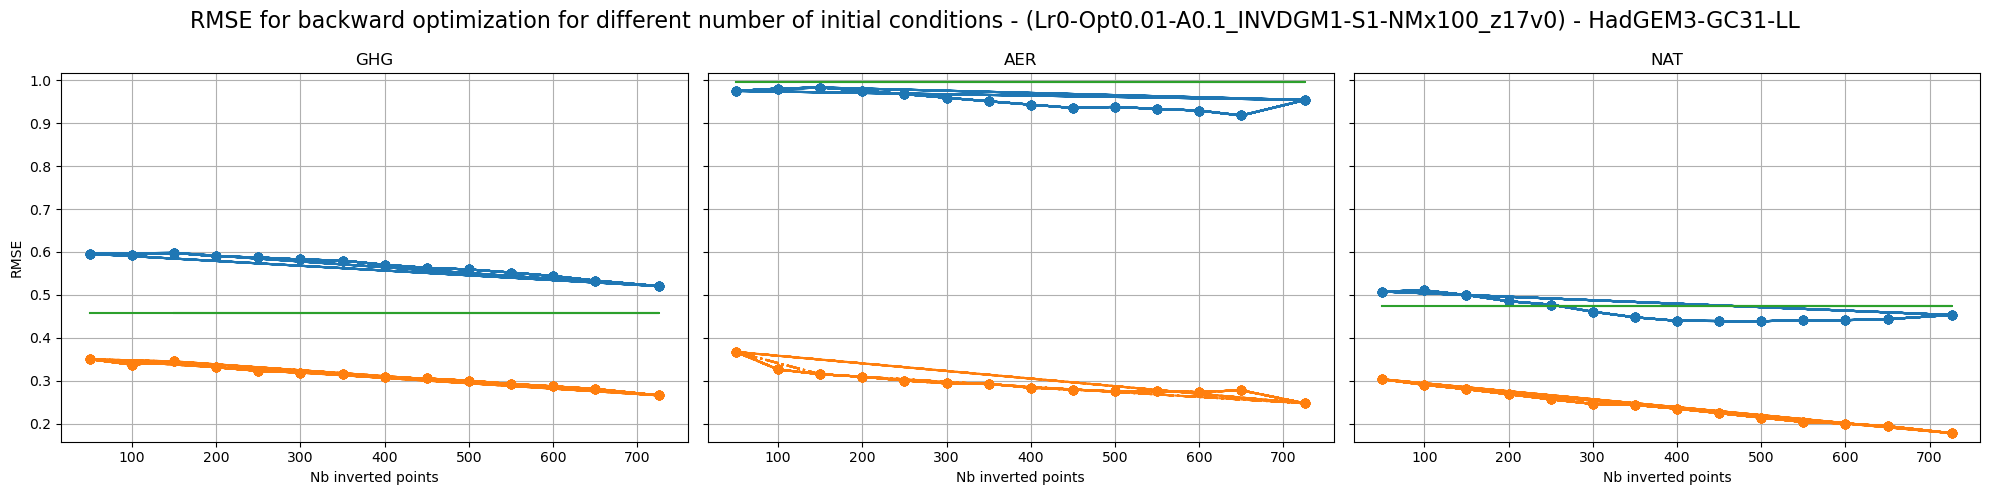

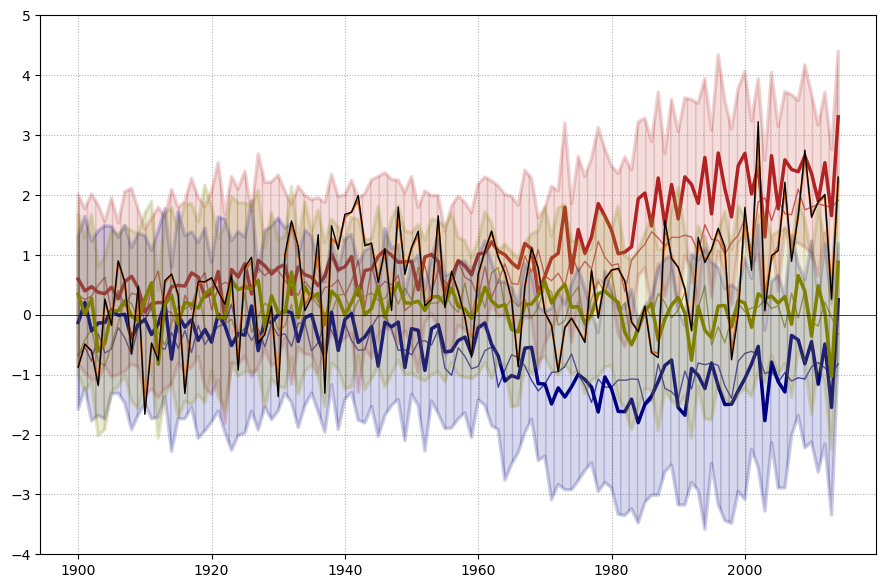

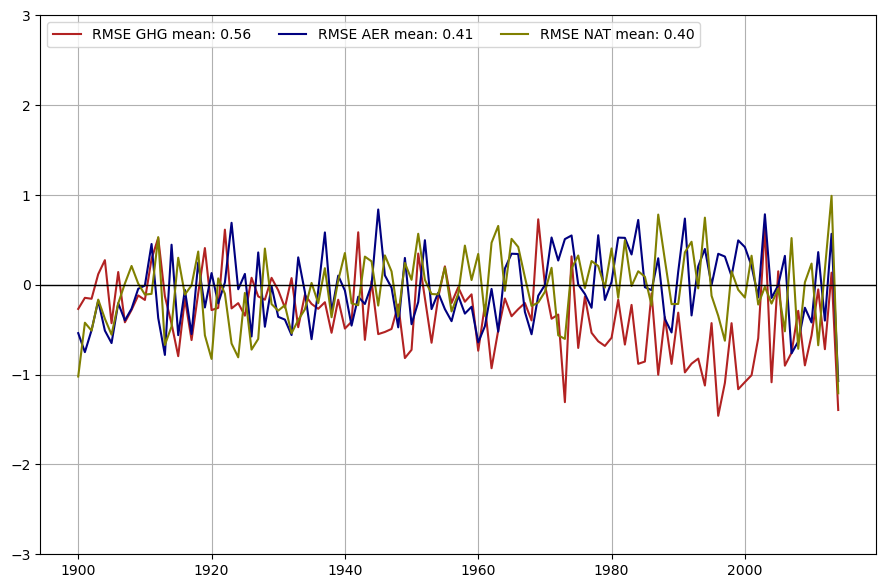

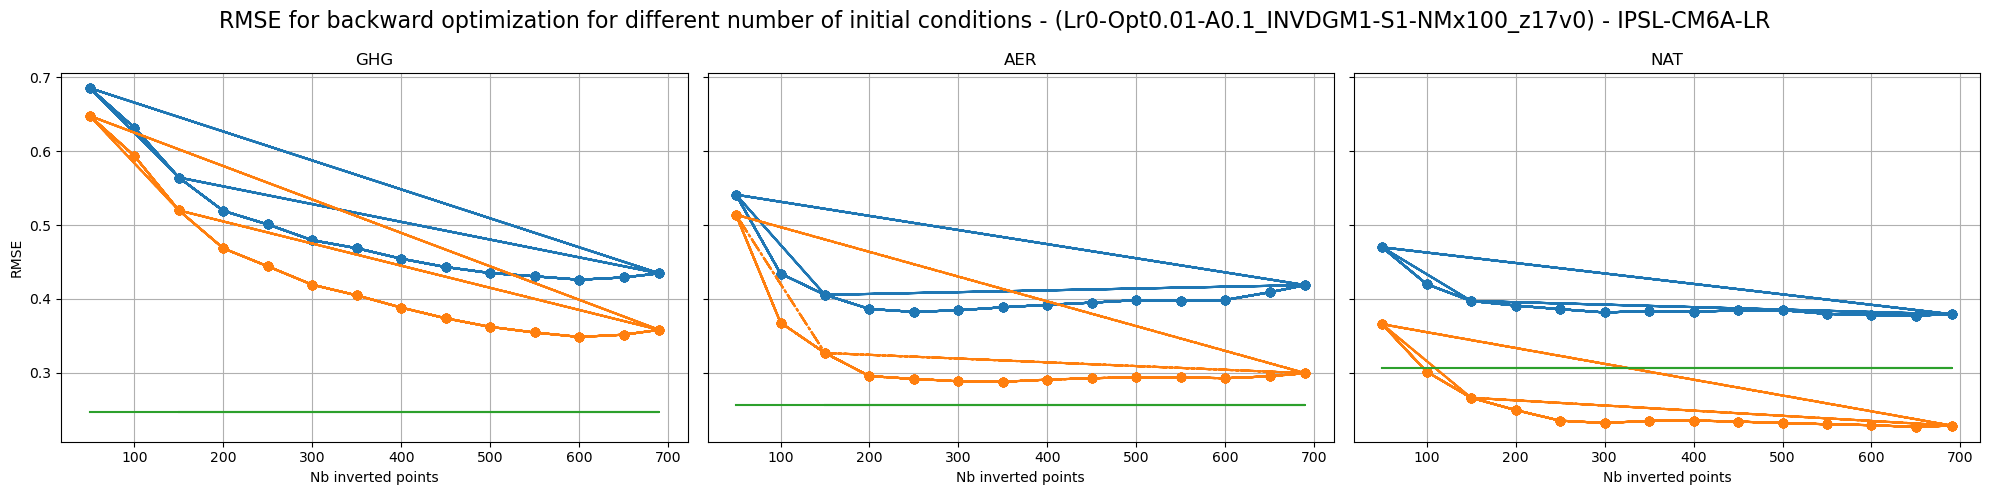

In [25]:
verbose = True
verbose_inv = True

if do_inversion_experiences :
    models_for_invert_and_plot_backup = models_for_invert_and_plot
    all_models_for_invert_and_plot = models_for_invert_and_plot
    
    print("\n# Inversion procedure for Trained Cases:\n")
    for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
        print(f"\n{'#'*132}\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
        print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4']
        #models_for_invert_and_plot = [ 'ACCESS-ESM1-5' ]
        #models_for_invert_and_plot = [ 'FGOALS-g3' ]
        #models_for_invert_and_plot = None

        for models_for_invert_and_plot in all_models_for_invert_and_plot :
            if np.isscalar(models_for_invert_and_plot) :
                models_for_invert_and_plot = [models_for_invert_and_plot]

            ## Plot inverted averaged by model all forcings profiles, show all models, by net

            if plot_averaged_inv_all_forcings_by_net_ok :
                #models_to_plot = [ 'NorESM2-LM' ]
                #models_to_plot = [ 'IPSL-CM6A-LR' ]
                #models_to_plot = [ 'FGOALS-g3' ]
                models_to_plot = models_for_invert_and_plot
                #models_to_plot = None
                invp.plot_averaged_inv_all_forcings_by_net(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                                                                   trained_with_all=trained_with_all,
                                                                   settings_label=current_inversion_settings_label,
                                                                   plot_src4inv=paiafbn_plot_src_Model_forc,
                                                                   plot_ini_x=paiafbn_plot_ini_forc,
                                                                   plot_inv_x=paiafbn_plot_inv_forc,
                                                                   plot_inv_filt_x = paiafbn_plot_inv_filt_forc,
                                                                   plot_mean_other_mod = paiafbn_plot_mean_other_mod,
                                                                   plot_hist_shaded_region = paiafbn_hist_shaded_region,
                                                                   plot_src4inv_hist = paiafbn_plot_src4inv_hist,  
                                                                   plot_src4inv_forc_shaded_region=paiafbn_plot_src4inv_forc_shaded_region,
                                                                   plot_src4inv_shaded_region = paiafbn_plot_src4inv_shaded_region,
                                                                   plot_src4inv_shaded_hist = paiafbn_plot_src4inv_shaded_hist,
                                                                   one_ax_by_forcing=one_ax_by_forcing,
                                                                   sset_sdir_dic=current_inv_ssettings_sdir_dic,
                                                                   load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok, 
                                                                   figs_dir=figs_dir, save_figs=True,
                                                                   models_to_plot=models_to_plot,
                                                                   lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                                                                   force_plot=force_ave_inv_all_forc_by_net, force_write=force_ave_inv_all_forc_by_net,
                                                                   plot_hist2inv = paiafbn_plot_hist2inv, plot_hist2inv_shaded_region = paiafbn_hist2inv_shaded_region,
                                                                   t_limits=all_forcings_t_limits,
                                                                   plot_forc_shaded_region=paiafbn_plot_forc_shaded_region,
                                                                   plot_inv_forc_shaded_region=inv_forc_shaded_region,
                                                                   plot_inv_hist_shaded_region=inv_hist_shaded_region,
                                                                   rmse_start_year = rmse_start_year,
                                                                   plot_inv_filt_forc_shaded_region = inv_filt_forc_shaded_region,
                                                                   plot_ini_forc_shaded_region=ini_forc_shaded_region, 
                                                                   errorlimits_percent=paiafbn_errorlimits_percent,
                                                                   verbose=verbose,
                                                                  )
                # invp.plot_averaged_inv_all_forcings_by_net(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                #                                            trained_with_all=trained_with_all,
                #                                            settings_label=current_inversion_settings_label,
                #                                            sset_sdir_dic=current_inv_ssettings_sdir_dic,
                #                                            load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok, 
                #                                            figs_dir=figs_dir, save_figs=save_figs,
                #                                            models_to_plot=models_to_plot,
                #                                            lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                #                                            force_plot=force_ave_inv_all_forc_by_net, force_write=force_ave_inv_all_forc_by_net,
                #                                            t_limits=all_forcings_t_limits,
                #                                            plot_forc_shaded_region=paiafbn_plot_forc_shaded_region,
                #                                            errorlimits_percent=paiafbn_errorlimits_percent,
                #                                            verbose=verbose,
                #                                           )
            else:
                print(f" ** 'plot_averaged_inv_all_forcings_by_net_ok' is not allowed **\n")

    models_for_invert_and_plot = models_for_invert_and_plot_backup

else:
    tmp_msg = f"'do_inversion_experiences' is not allowed"
    print(f"\n {'*'*80}\n ** {tmp_msg:^74} **\n {'*'*80}\n")

In [26]:
print(f"\nFIN d'Execution [{local_nb_label}]:\n  base_case_to_explore ... {base_case_to_explore}\n  sub_case_to_explore .... {sub_case_to_explore}\n  Date/heure d'arret ..... {dt.now()}")


FIN d'Execution [Nb5_TrainTestInvEssais-vPL0]:
  base_case_to_explore ... out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet
  sub_case_to_explore .... CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15
  Date/heure d'arret ..... 2023-08-03 15:52:28.315670


## Filtrage après inversion

In [27]:
'''path = "/.autofs/home/habbar/Bureau/data_nc/data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_1mod_EssaiTRwAll2/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e5000_bs100_Lr0.001-VfT15-TwALL/Inversion-on_IPSL-CM6A-LR/Inv_N0/Settings-Lr0.2-Opt0.01-A0.05_INVDGM1-S1-NMx100_z46v0/AVERAGED-SEL1RND-FROM31_best-val-net_XNearest600_yall/Inv_dic.p"
import pickle

# lire ce fichier .p 
def pickle_loader(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

pkl = pickle_loader(path)
print(pkl.keys())'''

'path = "/.autofs/home/habbar/Bureau/data_nc/data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_1mod_EssaiTRwAll2/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e5000_bs100_Lr0.001-VfT15-TwALL/Inversion-on_IPSL-CM6A-LR/Inv_N0/Settings-Lr0.2-Opt0.01-A0.05_INVDGM1-S1-NMx100_z46v0/AVERAGED-SEL1RND-FROM31_best-val-net_XNearest600_yall/Inv_dic.p"\nimport pickle\n\n# lire ce fichier .p \ndef pickle_loader(pickle_file):\n    with open(pickle_file, \'rb\') as file:\n        data = pickle.load(file)\n    return data\n\npkl = pickle_loader(path)\nprint(pkl.keys())'

In [28]:
import numpy as np
from scipy import signal
'''
# Define the high-pass filter parameters
order = 3
cutoff = 0.1
fs = 1.0

# Apply high-pass filter to Xinv
sos = signal.butter(order, cutoff, btype='high', fs=fs, output='sos')
Xinv_filtered = signal.sosfilt(sos, pkl['Xinv'], axis=1)

# Apply high-pass filter to Yinv
Yinv_filtered = signal.sosfilt(sos, pkl['Yinv'], axis=1)

#print(pkl['Xinv'].shape)
print('------------------------------------------------------------------------------------------------------------')
print(Yinv_filtered.shape)

print(np.array(pkl['Xinv']).shape)


#Lissage 
filt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}
b_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)

print(np.array(pkl['Xinv']).shape)
print(np.array(pkl['Yinv']).shape)
Xinv_filt = signal.filtfilt(b_lp_filter, a_lp_filter, pkl['Xinv'], axis=4)
print(Xinv_filt.shape)
Yinv_filt = signal.filtfilt(b_lp_filter, a_lp_filter, pkl['Yinv'], axis=3)
print(Yinv_filt.shape)'''

"\n# Define the high-pass filter parameters\norder = 3\ncutoff = 0.1\nfs = 1.0\n\n# Apply high-pass filter to Xinv\nsos = signal.butter(order, cutoff, btype='high', fs=fs, output='sos')\nXinv_filtered = signal.sosfilt(sos, pkl['Xinv'], axis=1)\n\n# Apply high-pass filter to Yinv\nYinv_filtered = signal.sosfilt(sos, pkl['Yinv'], axis=1)\n\n#print(pkl['Xinv'].shape)\nprint('------------------------------------------------------------------------------------------------------------')\nprint(Yinv_filtered.shape)\n\nprint(np.array(pkl['Xinv']).shape)\n\n\n#Lissage \nfilt_dic={ 'n':4, 'Wn':[1./10.], 'btype':'lowpass'}\nb_lp_filter, a_lp_filter = gt.filtering_forcing_signal_f(filt_dic, verbose=False)\n\nprint(np.array(pkl['Xinv']).shape)\nprint(np.array(pkl['Yinv']).shape)\nXinv_filt = signal.filtfilt(b_lp_filter, a_lp_filter, pkl['Xinv'], axis=4)\nprint(Xinv_filt.shape)\nYinv_filt = signal.filtfilt(b_lp_filter, a_lp_filter, pkl['Yinv'], axis=3)\nprint(Yinv_filt.shape)"

In [29]:
'''import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.array(pkl['Xinv'])[0,0,0,0,:].T, color = 'blue')
plt.plot(np.array(pkl['Yinv'])[0,0,0, :].T, color = 'black')
plt.plot(Xinv_filt[0,0,0,0,:].T, color = 'red')
plt.plot(Yinv_filt[0,0,0,:].T, color = 'orange')
plt.title('Filtered Xinv Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()'''

"import matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 5))\nplt.plot(np.array(pkl['Xinv'])[0,0,0,0,:].T, color = 'blue')\nplt.plot(np.array(pkl['Yinv'])[0,0,0, :].T, color = 'black')\nplt.plot(Xinv_filt[0,0,0,0,:].T, color = 'red')\nplt.plot(Yinv_filt[0,0,0,:].T, color = 'orange')\nplt.title('Filtered Xinv Data')\nplt.xlabel('Index')\nplt.ylabel('Value')\nplt.show()"

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_unet(data_inputs, data_targets, num_epochs=5000, learning_rate=0.001):
    # Convertir les données en tenseurs PyTorch
    inputs = torch.tensor(data_inputs, dtype=torch.float32)
    targets = torch.tensor(data_targets, dtype=torch.float32)

    # Définir la classe du U-Net
    class UNet(nn.Module):
        def __init__(self):
            super(UNet, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv1d(3, 24, kernel_size=7, stride=1),
                nn.Tanh(),
                nn.Conv1d(24, 24, kernel_size=7, stride=1),
                nn.Tanh()
            )
            self.decoder = nn.Sequential(
                nn.Conv1d(24, 1, kernel_size=7, stride=1),
                nn.Tanh()
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    # Créer une instance du U-Net
    net = UNet()

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Effectuer la boucle d'entraînement
    for epoch in range(num_epochs):
        # Réinitialiser les gradients des paramètres
        optimizer.zero_grad()

        # Passez les données d'entraînement dans le U-Net
        outputs = net(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

        # Afficher la perte pour chaque époque
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Retourner le modèle entraîné
    return net


import pickle
import numpy as np

# Charger les données d'entrée depuis les fichiers .p
with open("/.autofs/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-ghg_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p", 'rb') as file:
    data_input1 = pickle.load(file)

with open("/.autofs/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-nat_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p", 'rb') as file:
    data_input2 = pickle.load(file)

with open("/.autofs/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-aer_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p", 'rb') as file:
    data_input3 = pickle.load(file)

# Convertir les données en tableaux numpy
data_input1 = np.array(data_input1)
data_input2 = np.array(data_input2)
data_input3 = np.array(data_input3)

# Combiner les trois séries temporelles en une seule
data_inputs = np.concatenate((data_input1, data_input2, data_input3), axis=1)

# Charger les données cibles depuis un fichier .p
with open("/.autofs/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-hist_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p", 'rb') as file:
    data_targets = pickle.load(file)

# Convertir les données cibles en tableau numpy
data_targets = np.array(data_targets)

# Appeler la fonction d'entraînement du U-Net
#trained_model = train_unet(data_inputs, data_targets)

In [31]:
# ouvrir un fichiers .p
with open("/.autofs/home/habbar/Bureau/data_nc/stagelong/projetlong/data_source_dr/Region17/train-ghg_TTDGM2-S0-GAN85pc-N1000_z17v0_df.p", 'rb') as file:
    data_input1 = pickle.load(file)
    
# afficher le contenu du fichier .p
print(data_input1)

               model      1850      1851      1852      1853      1854  \
0      ACCESS-ESM1-5 -0.890730 -0.185708  0.151511 -1.808030 -0.254455   
1      ACCESS-ESM1-5 -0.798205 -0.762137  1.205322 -0.504540 -0.930353   
2      ACCESS-ESM1-5 -0.070414  0.909948 -0.132748 -1.092791 -0.407363   
3      ACCESS-ESM1-5 -0.070414  0.909948 -0.132748 -1.092791 -0.407363   
4      ACCESS-ESM1-5 -0.798205 -0.762137  1.205322 -0.504540 -0.930353   
...              ...       ...       ...       ...       ...       ...   
11995     NorESM2-LM  0.442415  0.262703  0.232307 -1.009595  0.606105   
11996     NorESM2-LM  0.291053  1.072641  1.312943  0.421058  0.466235   
11997     NorESM2-LM  0.291053  1.072641  1.312943  0.421058  0.466235   
11998     NorESM2-LM  0.291053  1.072641  1.312943  0.421058  0.466235   
11999     NorESM2-LM -0.594057 -0.194239  0.140831 -0.709343 -0.444913   

           1855      1856      1857      1858      1859      1860      1861  \
0     -0.305464 -0.097872 -0.405

# Europe new archit

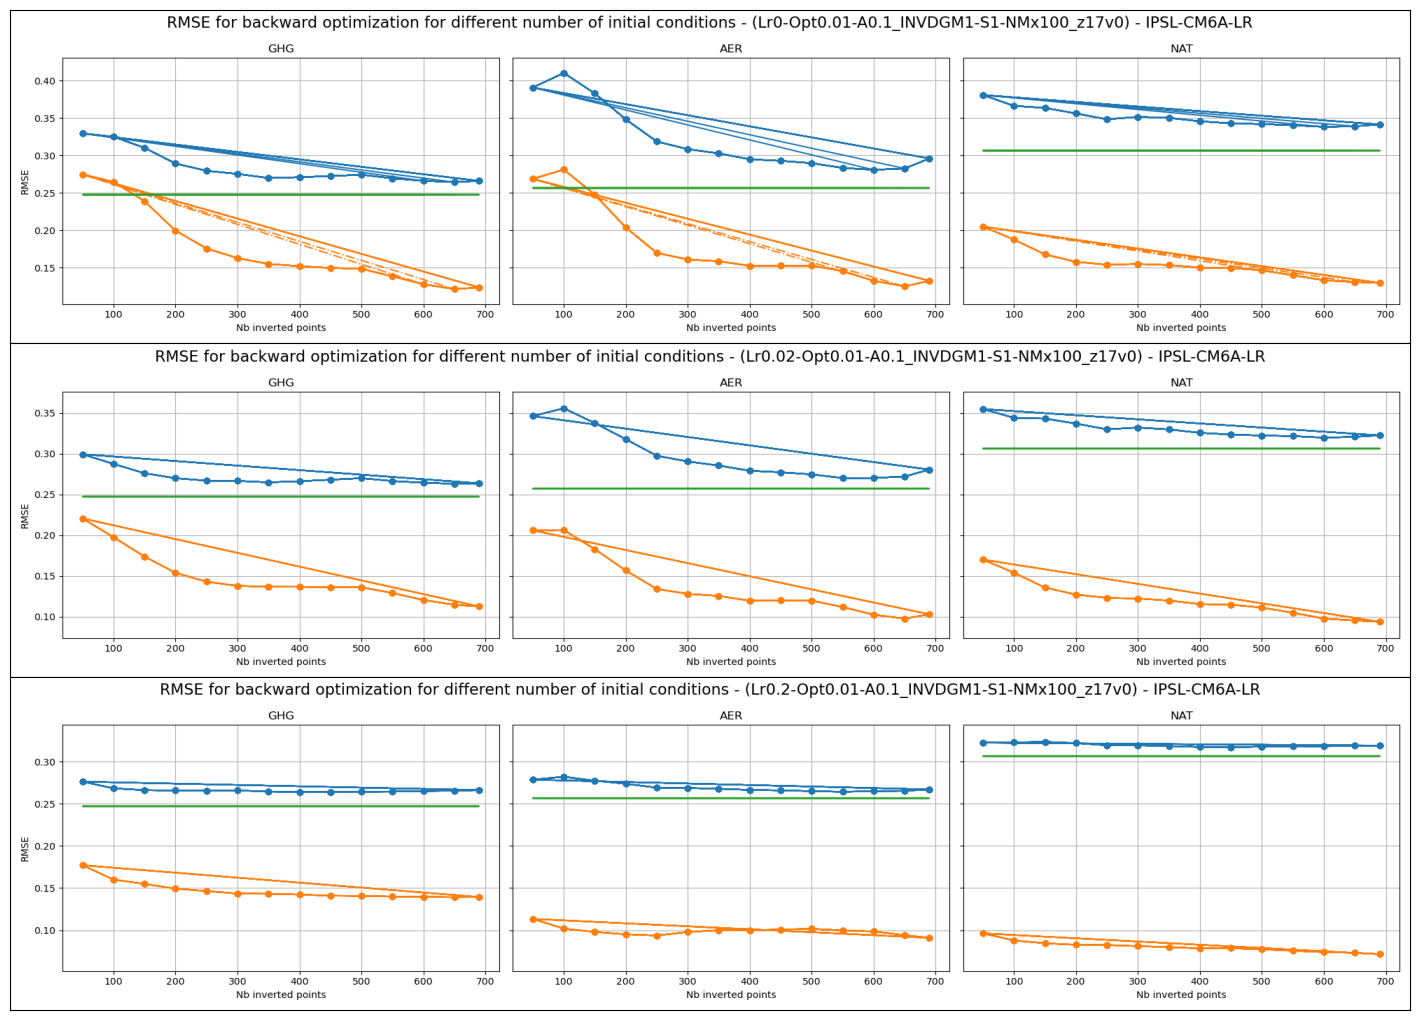

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

# Liste des modèles
inv_pt = ['0', '0.02', '0.2']

# Create a figure with 3 subplots in a vertical layout (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))
#model = 'CanESM5'
#model = 'FGOALS-g3'
#model = 'HadGEM3-GC31-LL'
model = 'IPSL-CM6A-LR'

# Loop over the models
for i, inv_pt in enumerate(inv_pt):
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM65_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM6_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM5_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM31_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    
    
    # Load the image using PIL
    image = Image.open(image_path)

    # Display the image on the corresponding subplot with aspect='auto'
    axes[i].imshow(image, aspect='auto')

    # Hide axes ticks and labels for a cleaner plot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove all vertical space between subplots
plt.subplots_adjust(hspace=0)

# Remove padding between subplots
plt.tight_layout(pad=0)
# Save the figure en donnant un nom 
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/RMSE_for_chosen_{model}.png', dpi=300)

# Show the plot
plt.show()

# Europe old archit

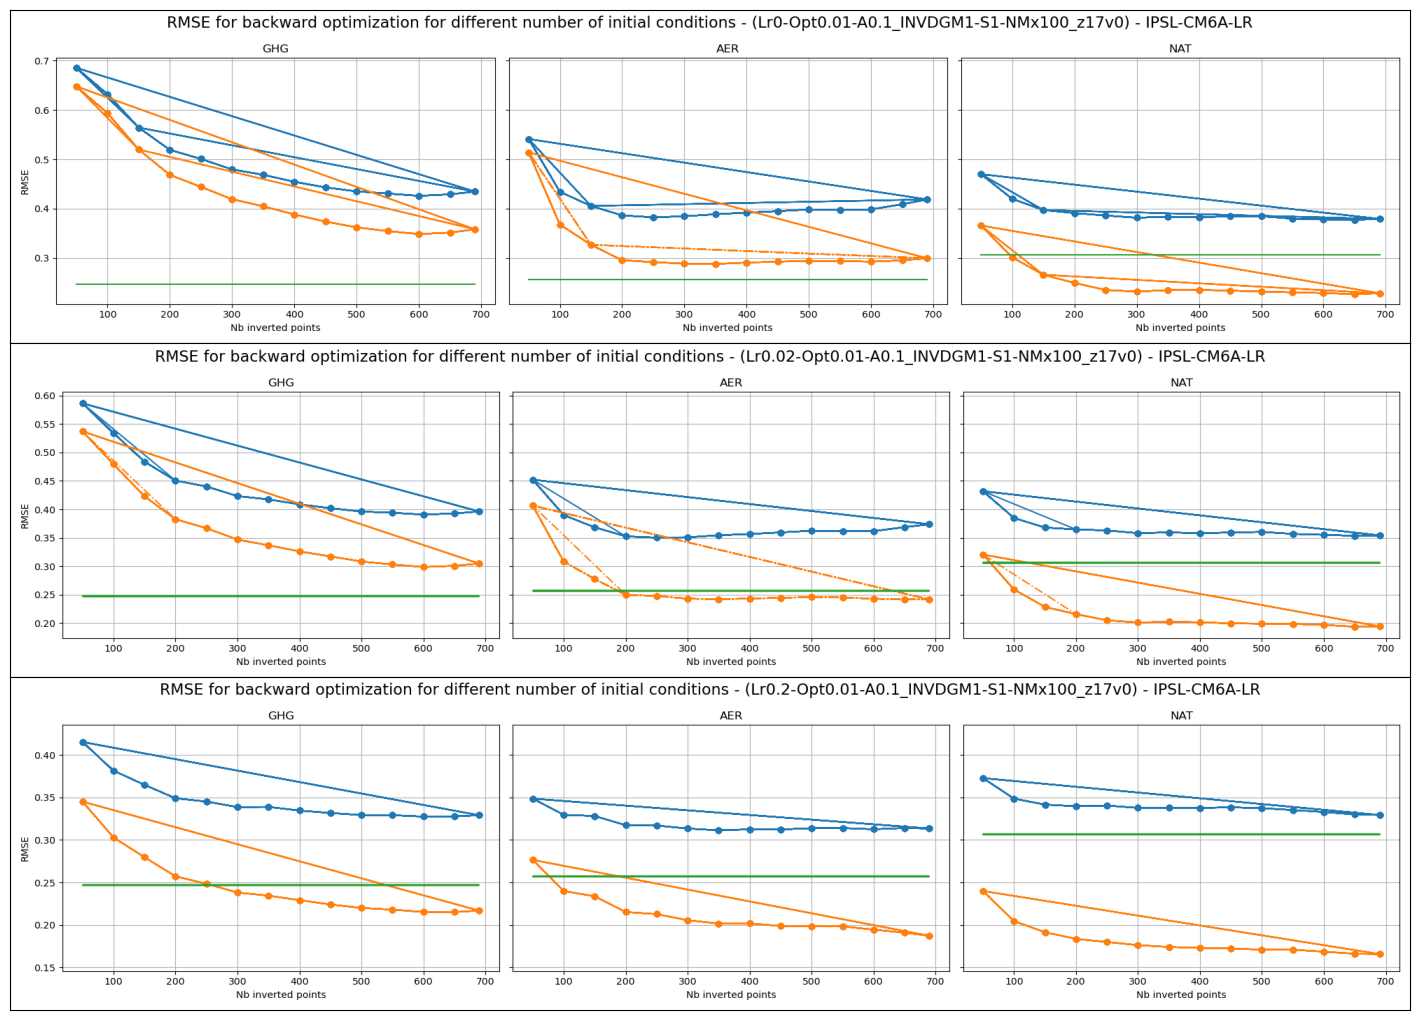

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

# Liste des modèles
inv_pt = ['0', '0.02', '0.2']

# Create a figure with 3 subplots in a vertical layout (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))
#model = 'CanESM5'
#model = 'FGOALS-g3'
#model = 'HadGEM3-GC31-LL'
model = 'IPSL-CM6A-LR'

# Loop over the models
for i, inv_pt in enumerate(inv_pt):
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM65_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM6_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM5_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/{model}/SEL1RND-FROM31_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc-Xothmod.png"
    
    
    # Load the image using PIL
    image = Image.open(image_path)

    # Display the image on the corresponding subplot with aspect='auto'
    axes[i].imshow(image, aspect='auto')

    # Hide axes ticks and labels for a cleaner plot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove all vertical space between subplots
plt.subplots_adjust(hspace=0)

# Remove padding between subplots
plt.tight_layout(pad=0)
# Save the figure en donnant un nom 
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/RMSE_for_chosen_{model}.png', dpi=300)

# Show the plot
plt.show()

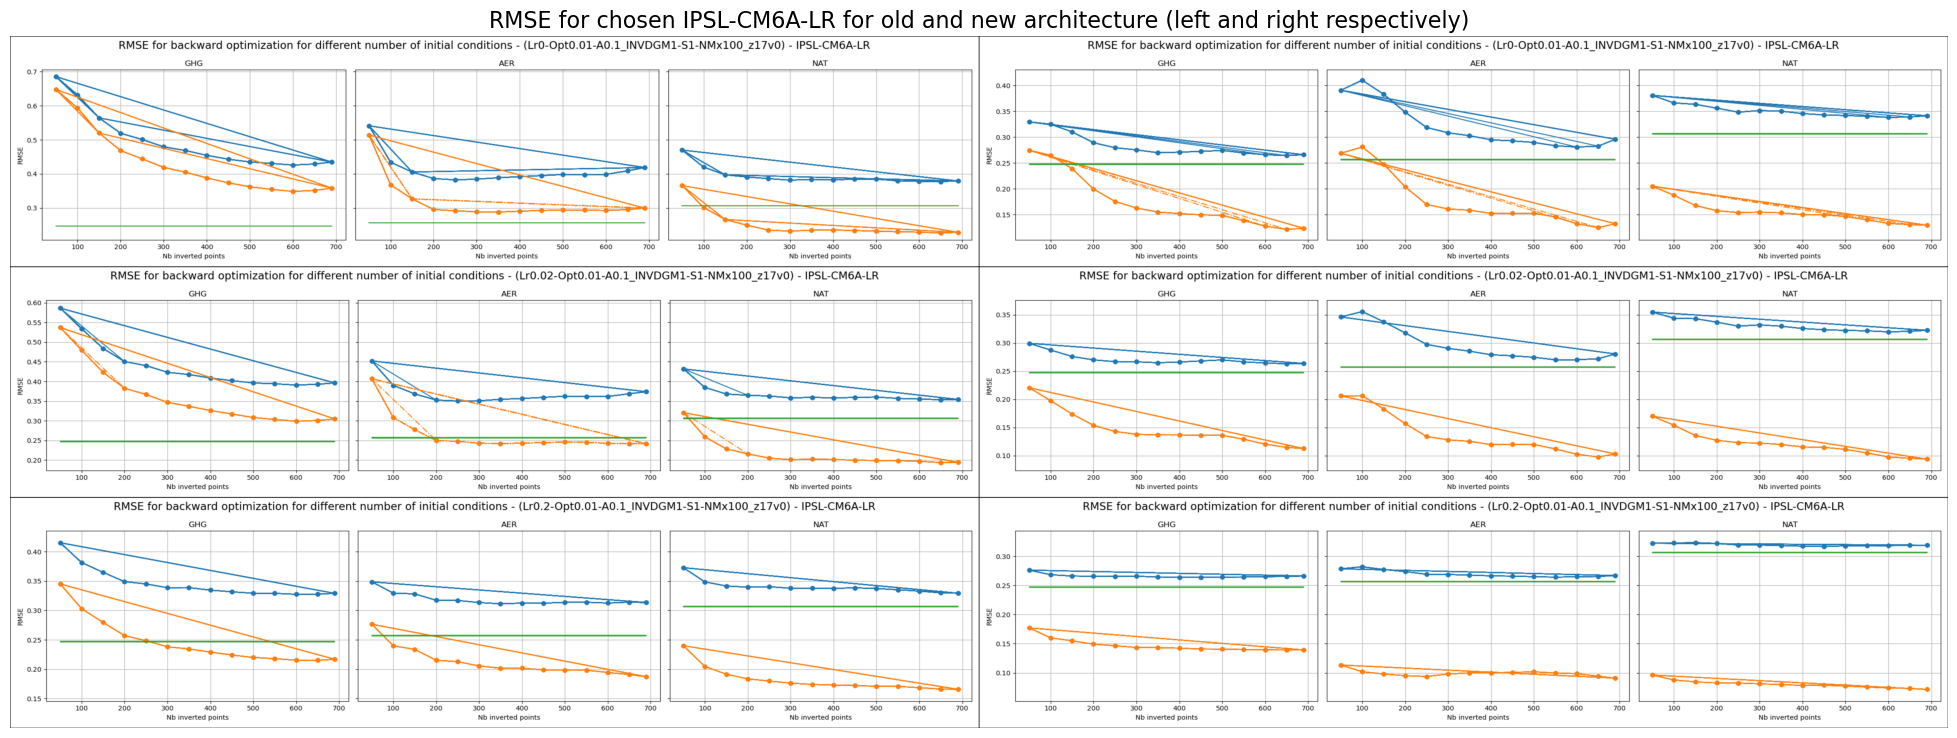

In [34]:
# rassembler les deux dernières images générées en une seule image à gauche old architecture, à droite new architecture

import numpy as np
import matplotlib.pyplot as plt

# load image  
img1 = plt.imread(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/RMSE_for_chosen_{model}.png')  
img2 = plt.imread(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/RMSE_for_chosen_{model}.png')

# concatenate images
img = np.concatenate((img1, img2), axis=1)

# plot concatenated image
plt.figure(figsize=(25,10))
plt.imshow(img)
plt.axis('off')
plt.title(f'RMSE for chosen {model} for old and new architecture (left and right respectively)', fontsize=16)
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/RMSE_for_chosen_{model}_old_new_arch.png', dpi=300)
plt.show()

# Arctic new archit

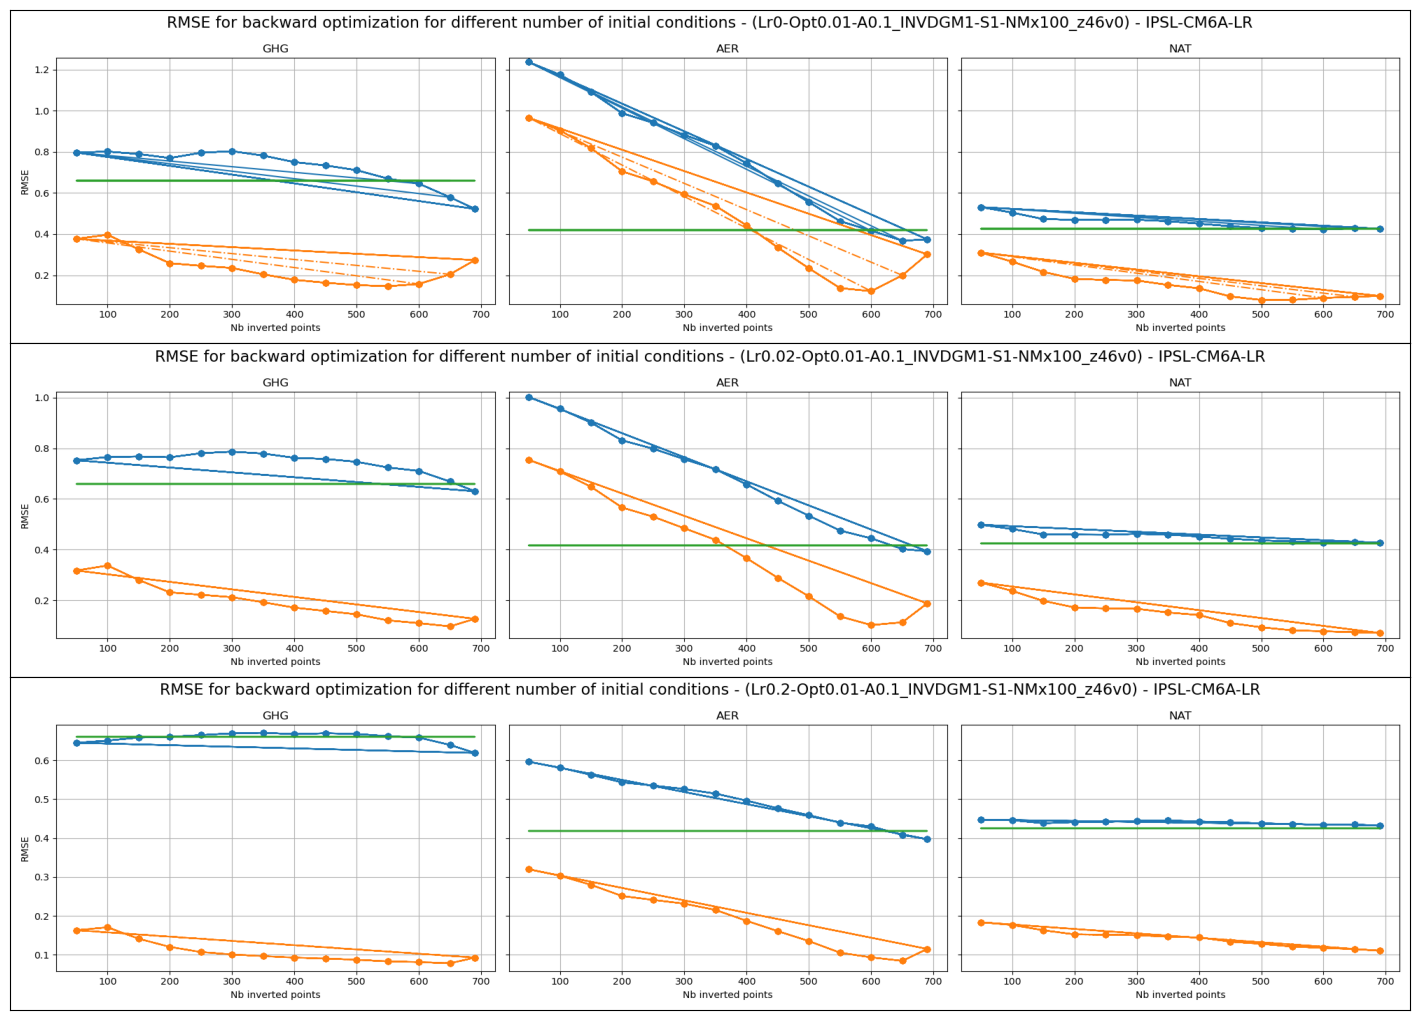

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

# Liste des modèles
inv_pt = ['0', '0.02', '0.2']

# Create a figure with 3 subplots in a vertical layout (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))
#model = 'CanESM5'
#model = 'FGOALS-g3'
#model = 'HadGEM3-GC31-LL'
model = 'IPSL-CM6A-LR'

# Loop over the models
for i, inv_pt in enumerate(inv_pt):
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM65_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM6_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM5_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM31_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    
    
    # Load the image using PIL
    image = Image.open(image_path)

    # Display the image on the corresponding subplot with aspect='auto'
    axes[i].imshow(image, aspect='auto')

    # Hide axes ticks and labels for a cleaner plot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove all vertical space between subplots
plt.subplots_adjust(hspace=0)

# Remove padding between subplots
plt.tight_layout(pad=0)
# Save the figure en donnant un nom 
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/RMSE_for_chosen_{model}.png', dpi=300)

# Show the plot
plt.show()

# Arctic old archit

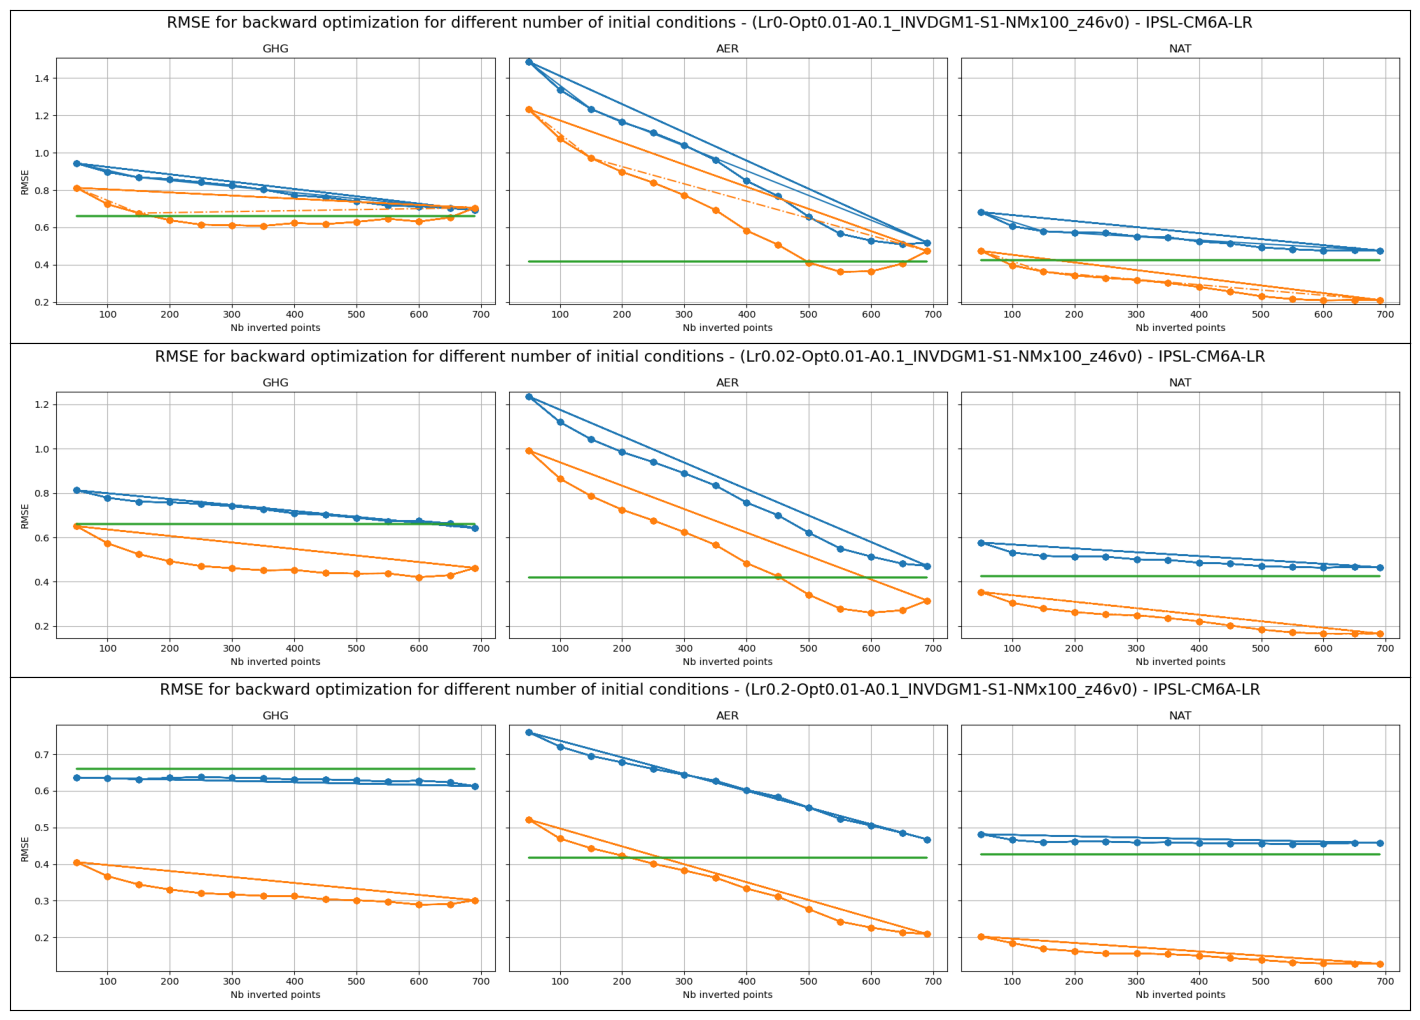

In [36]:
import matplotlib.pyplot as plt
from PIL import Image

# Liste des modèles
inv_pt = ['0', '0.02', '0.2']

# Create a figure with 3 subplots in a vertical layout (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))
#model = 'CanESM5'
#model = 'FGOALS-g3'
#model = 'HadGEM3-GC31-LL'
model = 'IPSL-CM6A-LR'

# Loop over the models
for i, inv_pt in enumerate(inv_pt):
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM65_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM6_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    #image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM5_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    image_path = f"/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/Settings-Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/{model}/SEL1RND-FROM31_best-val-net/RMSE_Lr{inv_pt}-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc-Xothmod.png"
    
    
    # Load the image using PIL
    image = Image.open(image_path)

    # Display the image on the corresponding subplot with aspect='auto'
    axes[i].imshow(image, aspect='auto')

    # Hide axes ticks and labels for a cleaner plot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove all vertical space between subplots
plt.subplots_adjust(hspace=0)

# Remove padding between subplots
plt.tight_layout(pad=0)
# Save the figure en donnant un nom 
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/RMSE_for_chosen_{model}.png', dpi=300)

# Show the plot
plt.show()

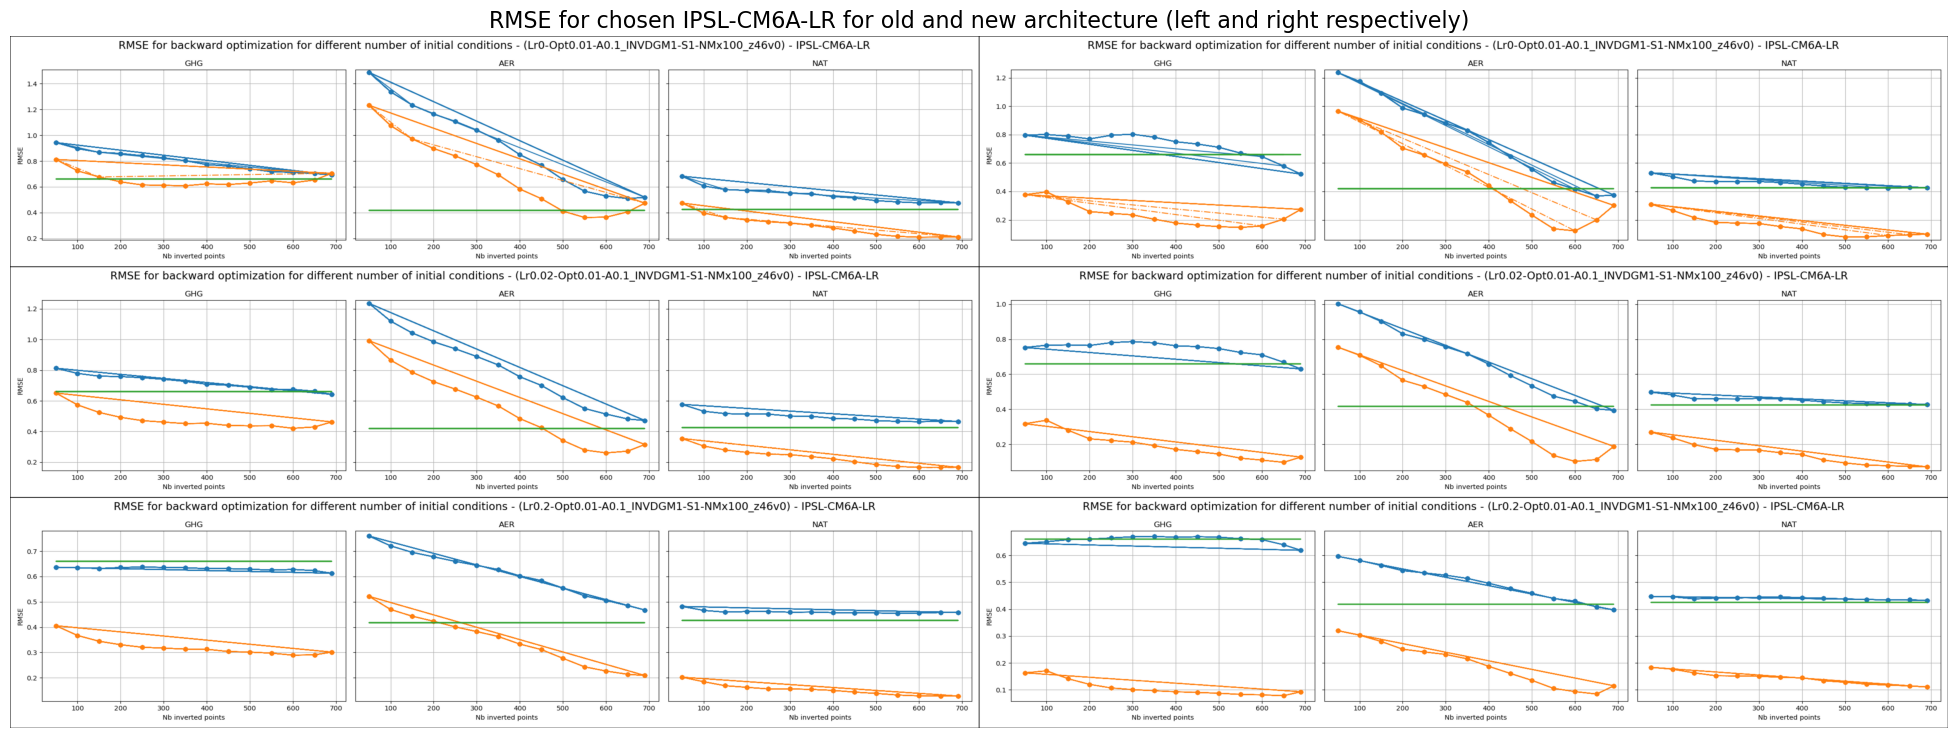

In [37]:
# rassembler les deux dernières images générées en une seule image à gauche old architecture, à droite new architecture

import numpy as np
import matplotlib.pyplot as plt

# load image  
img1 = plt.imread(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e500_bs100_Lr0.001-VfT15/RMSE_for_chosen_{model}.png')  
img2 = plt.imread(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/RMSE_for_chosen_{model}.png')

# concatenate images
img = np.concatenate((img1, img2), axis=1)

# plot concatenated image
plt.figure(figsize=(25,10))
plt.imshow(img)
plt.axis('off')
plt.title(f'RMSE for chosen {model} for old and new architecture (left and right respectively)', fontsize=16)
plt.savefig(f'/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/RMSE_for_chosen_{model}_old_new_arch.png', dpi=300)
plt.show()

# ROF vs Backward optimization Europe

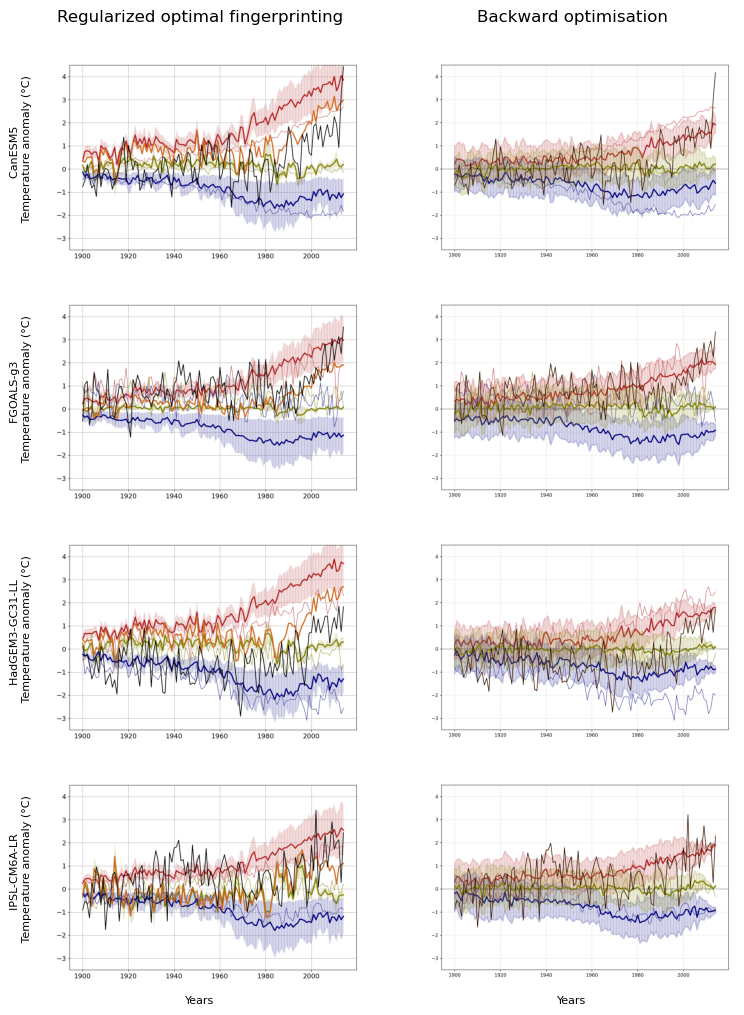

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

top    = 0.98; bottom = 0.02
left   = 0.05; right  = 0.98
hspace = 0.; wspace = 0.

# Create a figure with 4 subplots in a vertical layout (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10), gridspec_kw={'hspace': hspace, 'wspace': wspace,
                                             'left': left, 'right': right,
                                             'top': top, 'bottom': bottom })

# Import images
img1 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/CanESM5/CanESM5_result.png")
img2 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/FGOALS-g3/FGOALS-g3_result.png")
img3 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/HadGEM3-GC31-LL/HadGEM3-GC31-LL_result.png")
img4 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/IPSL-CM6A-LR/IPSL-CM6A-LR_result.png")

img5 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/CanESM5/SEL1RND-FROM65_best-val-net_XNearest200_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-CanESM5_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img6 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/FGOALS-g3/SEL1RND-FROM6_best-val-net_XNearest200_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-FGOALS-g3_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img7 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/HadGEM3-GC31-LL/SEL1RND-FROM5_best-val-net_XNearest200_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-HadGEM3-GC31-LL_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img8 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/IPSL-CM6A-LR/SEL1RND-FROM31_best-val-net_XNearest400_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-IPSL-CM6A-LR_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")

# Plot images img1, img2, img3, img4 on the 1st column and img5, img6, img7, img8 on the 2nd column
axes[0, 0].imshow(img1)
axes[0, 0].set_ylabel('CanESM5 \n Temperature anomaly (°C)', fontsize=8)
axes[1, 0].imshow(img2)
axes[1, 0].set_ylabel('FGOALS-g3 \n Temperature anomaly (°C)', fontsize=8)
axes[2, 0].imshow(img3)
axes[2, 0].set_ylabel('HadGEM3-GC31-LL \n Temperature anomaly (°C)', fontsize=8)
axes[3, 0].imshow(img4)
axes[3, 0].set_ylabel('IPSL-CM6A-LR \n Temperature anomaly (°C)', fontsize=8)
axes[3, 0].set_xlabel("Years", fontsize=8)

axes[0, 1].imshow(img5) 
axes[1, 1].imshow(img6) 
axes[2, 1].imshow(img7)
axes[3, 1].imshow(img8)
axes[3, 1].set_xlabel("Years", fontsize=8)

# Remove the x and y ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Remove frame (border) around the images
    
# titre pour la colonne 1 et centré
axes[0, 0].set_title('Regularized optimal fingerprinting', fontsize=12, loc='center')
# titre pour la colonne 2
axes[0, 1].set_title('Backward optimisation', fontsize=12, loc='center')

# Remove all vertical space between subplots and set aspect ratio to equal
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/AllModels_rof_vs_backoptim.png", dpi=300)

# Show the figure
plt.show()

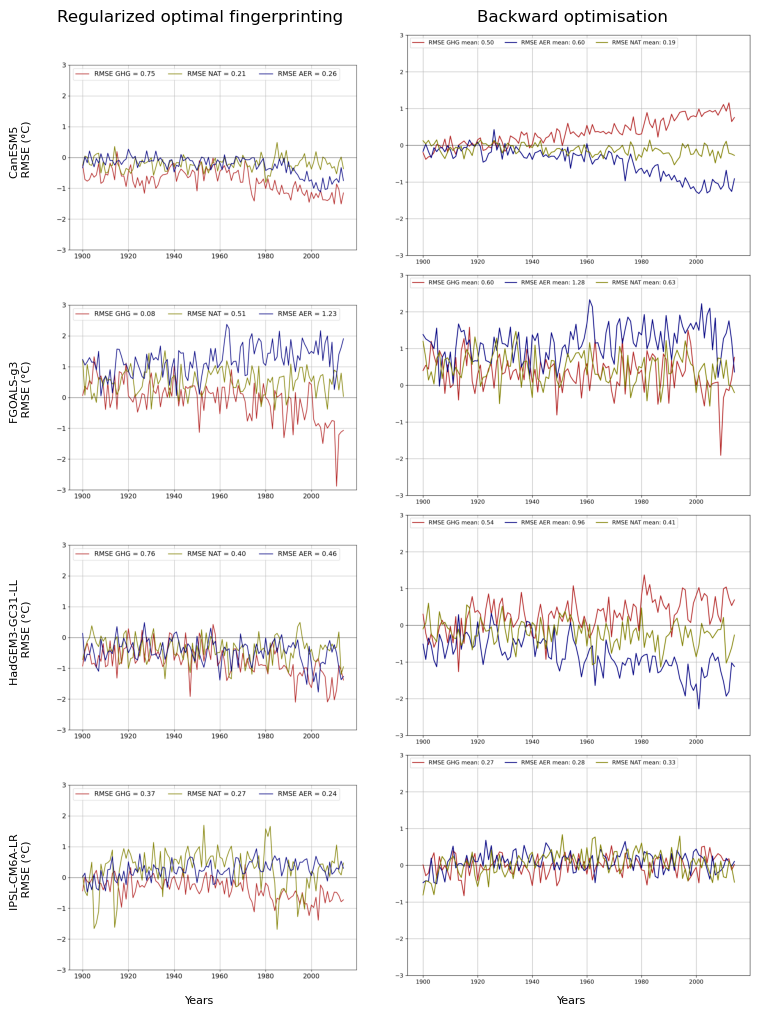

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

top    = 0.98; bottom = 0.02
left   = 0.05; right  = 0.98
hspace = 0.; wspace = 0.

# Create a figure with 4 subplots in a vertical layout (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10), gridspec_kw={'hspace': hspace, 'wspace': wspace,
                                             'left': left, 'right': right,
                                             'top': top, 'bottom': bottom })

# Import images
img1 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/CanESM5/CanESM5_rmse.png")
img2 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/FGOALS-g3/FGOALS-g3_rmse.png")
img3 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/HadGEM3-GC31-LL/HadGEM3-GC31-LL_rmse.png")
img4 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Europe/IPSL-CM6A-LR/IPSL-CM6A-LR_rmse.png")

img5 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/CanESM5/SEL1RND-FROM65_best-val-net_XNearest200_yall/dist_Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc_all_forcings.png")
img6 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/FGOALS-g3/SEL1RND-FROM6_best-val-net_XNearest200_yall/dist_Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc_all_forcings.png")
img7 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/HadGEM3-GC31-LL/SEL1RND-FROM5_best-val-net_XNearest200_yall/dist_Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc_all_forcings.png")
img8 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7-7_nCh96_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0013677803220430093-VfT15/Settings-Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0/IPSL-CM6A-LR/SEL1RND-FROM31_best-val-net_XNearest400_yall/dist_Lr0.02-Opt0.01-A0.1_INVDGM1-S1-NMx100_z17v0_Xinv-Xsrc_all_forcings.png")

# Plot images img1, img2, img3, img4 on the 1st column and img5, img6, img7, img8 on the 2nd column
axes[0, 0].imshow(img1)
axes[0, 0].set_ylabel('CanESM5 \n RMSE (°C)', fontsize=8)
axes[1, 0].imshow(img2)
axes[1, 0].set_ylabel('FGOALS-g3 \n RMSE (°C)', fontsize=8)
axes[2, 0].imshow(img3)
axes[2, 0].set_ylabel('HadGEM3-GC31-LL \n RMSE (°C)', fontsize=8)
axes[3, 0].imshow(img4)
axes[3, 0].set_ylabel('IPSL-CM6A-LR \n RMSE (°C)', fontsize=8)
axes[3, 0].set_xlabel("Years", fontsize=8)

axes[0, 1].imshow(img5) 
axes[1, 1].imshow(img6) 
axes[2, 1].imshow(img7)
axes[3, 1].imshow(img8)
axes[3, 1].set_xlabel("Years", fontsize=8)

# Remove the x and y ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Remove frame (border) around the images
    
# titre pour la colonne 1 et centré
axes[0, 0].set_title('Regularized optimal fingerprinting', fontsize=12, loc='center')
# titre pour la colonne 2
axes[0, 1].set_title('Backward optimisation', fontsize=12, loc='center')

# Remove all vertical space between subplots and set aspect ratio to equal
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z17v0_4mod_NewNet/AllModels_rof_vs_backoptim_rmse.png", dpi=300)

# Show the figure
plt.show()

# ROF vs Backward optimization Arctic

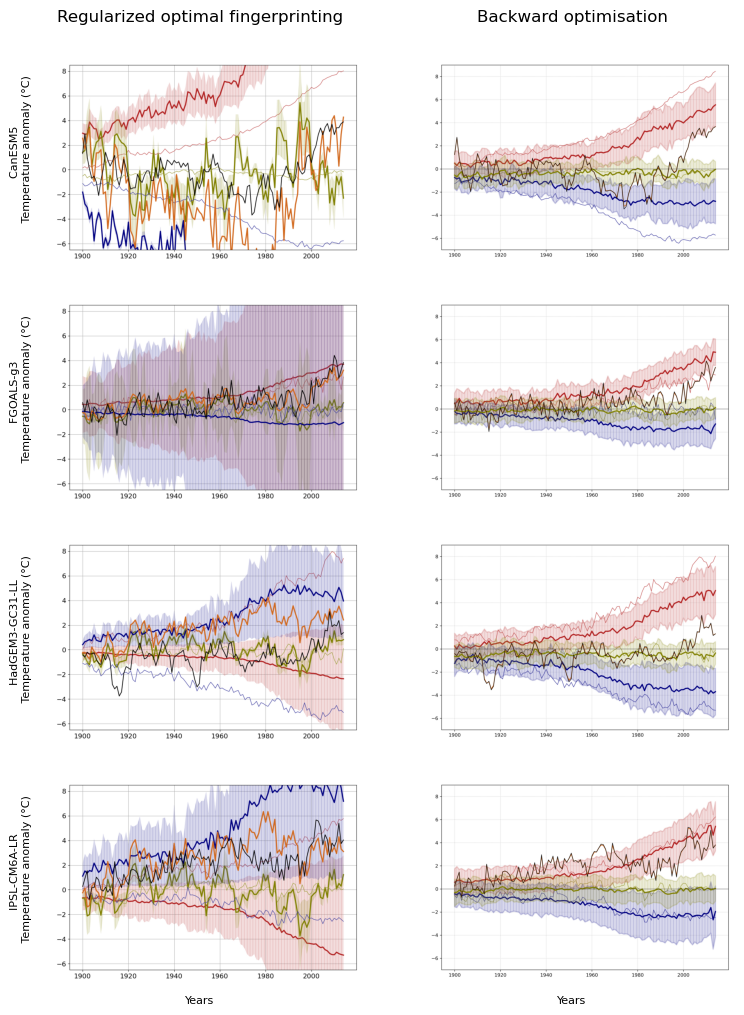

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

top    = 0.98; bottom = 0.02
left   = 0.05; right  = 0.98
hspace = 0.; wspace = 0.

# Create a figure with 4 subplots in a vertical layout (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10), gridspec_kw={'hspace': hspace, 'wspace': wspace,
                                             'left': left, 'right': right,
                                             'top': top, 'bottom': bottom })

# Import images
img1 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/CanESM5/CanESM5_result.png")
img2 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/FGOALS-g3/FGOALS-g3_result.png")
img3 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/HadGEM3-GC31-LL/HadGEM3-GC31-LL_result.png")
img4 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/IPSL-CM6A-LR/IPSL-CM6A-LR_result.png")

img5 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/CanESM5/SEL1RND-FROM65_best-val-net_XNearest150_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-CanESM5_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img6 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/FGOALS-g3/SEL1RND-FROM6_best-val-net_XNearest150_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-FGOALS-g3_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img7 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/HadGEM3-GC31-LL/SEL1RND-FROM5_best-val-net_XNearest150_yall/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-HadGEM3-GC31-LL_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")
img8 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/IPSL-CM6A-LR/SEL1RND-FROM31_best-val-net/FigPlotAveInvAllForcfByNet_inverted-averaged-all-forcings-1-models-1-models-IPSL-CM6A-LR_net-0_best-val_+XsrcMod_+XinvMod_FIX-T_Shaded-1xSTD.png")

# Plot images img1, img2, img3, img4 on the 1st column and img5, img6, img7, img8 on the 2nd column
axes[0, 0].imshow(img1)
axes[0, 0].set_ylabel('CanESM5 \n Temperature anomaly (°C)', fontsize=8)
axes[1, 0].imshow(img2)
axes[1, 0].set_ylabel('FGOALS-g3 \n Temperature anomaly (°C)', fontsize=8)
axes[2, 0].imshow(img3)
axes[2, 0].set_ylabel('HadGEM3-GC31-LL \n Temperature anomaly (°C)', fontsize=8)
axes[3, 0].imshow(img4)
axes[3, 0].set_ylabel('IPSL-CM6A-LR \n Temperature anomaly (°C)', fontsize=8)
axes[3, 0].set_xlabel("Years", fontsize=8)

axes[0, 1].imshow(img5) 
axes[1, 1].imshow(img6) 
axes[2, 1].imshow(img7)
axes[3, 1].imshow(img8)
axes[3, 1].set_xlabel("Years", fontsize=8)

# Remove the x and y ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Remove frame (border) around the images
    
# titre pour la colonne 1 
axes[0, 0].set_title('Regularized optimal fingerprinting', fontsize=12, loc='center')
# titre pour la colonne 2
axes[0, 1].set_title('Backward optimisation', fontsize=12, loc='center')

# Remove all vertical space between subplots and set aspect ratio to equal
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/AllModels_rof_vs_backoptim.png", dpi=300)

# Show the figure
plt.show()

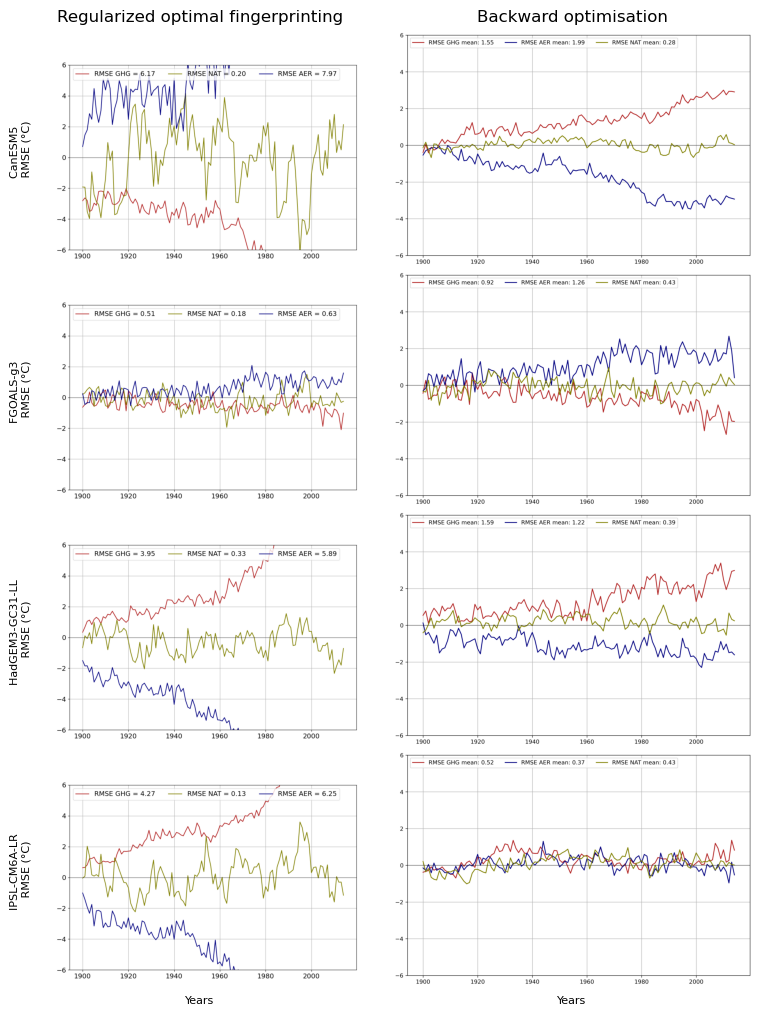

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

top    = 0.98; bottom = 0.02
left   = 0.05; right  = 0.98
hspace = 0.; wspace = 0.

# Create a figure with 4 subplots in a vertical layout (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10), gridspec_kw={'hspace': hspace, 'wspace': wspace,
                                             'left': left, 'right': right,
                                             'top': top, 'bottom': bottom })

# Import images
img1 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/CanESM5/CanESM5_rmse.png")
img2 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/FGOALS-g3/FGOALS-g3_rmse.png")
img3 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/HadGEM3-GC31-LL/HadGEM3-GC31-LL_rmse.png")
img4 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/IPSL-CM6A-LR/IPSL-CM6A-LR_rmse.png")

img5 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/CanESM5/SEL1RND-FROM65_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png")
img6 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/FGOALS-g3/SEL1RND-FROM6_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png")
img7 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/HadGEM3-GC31-LL/SEL1RND-FROM5_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png")
img8 = plt.imread("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/IPSL-CM6A-LR/SEL1RND-FROM31_best-val-net/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png")

# Plot images img1, img2, img3, img4 on the 1st column and img5, img6, img7, img8 on the 2nd column
axes[0, 0].imshow(img1)
axes[0, 0].set_ylabel('CanESM5 \n RMSE (°C)', fontsize=8)
axes[1, 0].imshow(img2)
axes[1, 0].set_ylabel('FGOALS-g3 \n RMSE (°C)', fontsize=8)
axes[2, 0].imshow(img3)
axes[2, 0].set_ylabel('HadGEM3-GC31-LL \n RMSE (°C)', fontsize=8)
axes[3, 0].imshow(img4)
axes[3, 0].set_ylabel('IPSL-CM6A-LR \n RMSE (°C)', fontsize=8)
axes[3, 0].set_xlabel("Years", fontsize=8)

axes[0, 1].imshow(img5) 
axes[1, 1].imshow(img6) 
axes[2, 1].imshow(img7)
axes[3, 1].imshow(img8)
axes[3, 1].set_xlabel("Years", fontsize=8)

# Remove the x and y ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Remove frame (border) around the images
    
# titre pour la colonne 1 et centré
axes[0, 0].set_title('Regularized optimal fingerprinting', fontsize=12, loc='center')
# titre pour la colonne 2
axes[0, 1].set_title('Backward optimisation', fontsize=12, loc='center')

# Remove all vertical space between subplots and set aspect ratio to equal
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/AllModels_rof_vs_backoptim_rmse.png", dpi=300)

# Show the figure
plt.show()

In [4]:
from PIL import Image

# Chemins vers les images
image_paths_1st_col = [
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/CanESM5/CanESM5_rmse.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/FGOALS-g3/FGOALS-g3_rmse.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/HadGEM3-GC31-LL/HadGEM3-GC31-LL_rmse.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/ROF/Arctic/IPSL-CM6A-LR/IPSL-CM6A-LR_rmse.png",
]

image_paths_2nd_col = [
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/CanESM5/SEL1RND-FROM65_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/FGOALS-g3/SEL1RND-FROM6_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/HadGEM3-GC31-LL/SEL1RND-FROM5_best-val-net_XNearest150_yall/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png",
    "/net/pallas/usr/neuro/com/habbar/projet/data_nc/Figs/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z46v0_4mod_NewNet/CNN_Ks7-7-7-7-7-7_nCh64_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.0009096313789794583-VfT15/Settings-Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0/IPSL-CM6A-LR/SEL1RND-FROM31_best-val-net/dist_Lr0-Opt0.01-A0.1_INVDGM1-S1-NMx100_z46v0_Xinv-Xsrc_all_forcings.png",
]

# Charger les images
images_1st_col = [Image.open(path) for path in image_paths_1st_col]
images_2nd_col = [Image.open(path) for path in image_paths_2nd_col]

# Initialisation des dimensions de l'image finale
final_width = 0
final_height = 0

# Liste pour stocker les images combinées
combined_images = []

# Créer et sauvegarder des images combinées
for i in range(4):
    img1 = images_1st_col[i]
    img2 = images_2nd_col[i]

    # Redimensionner si nécessaire
    if img1.size != img2.size:
        img2 = img2.resize(img1.size)

    # Créer une nouvelle image pour coller img1 et img2 côte à côte
    new_image = Image.new('RGB', (img1.width + img2.width, img1.height))

    # Coller img1 et img2
    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (img1.width, 0))

    # Ajouter à la liste des images combinées
    combined_images.append(new_image)

    # Mise à jour des dimensions de l'image finale
    final_width = max(final_width, new_image.width)
    final_height += new_image.height

# Créer une image finale pour coller toutes les images combinées
final_image = Image.new('RGB', (final_width, final_height))

# Position verticale actuelle pour le collage dans l'image finale
current_height = 0

# Coller toutes les images combinées dans l'image finale
for combined_image in combined_images:
    final_image.paste(combined_image, (0, current_height))
    current_height += combined_image.height

# Sauvegarder l'image finale
final_image.save("concatenated_image.png")